## Setup - imports, time, parameters, size function

In [1]:
runno = '7485'

In [2]:
from invisible_cities.database import load_db

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sys import getsizeof

In [4]:
import sys

def get_size(obj, seen=None,):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

In [5]:
from time import time as time
t0 = time()

In [6]:
# Fit functions

def gauss(x, A, m, s):
    if s < 0:
        return 10000000000000000
    return A*np.exp(-(x-m)**2 / (2*s**2))

def gauss2(x, A, m, v): 
    if v <= 0:
        return 1e10
    return A*np.exp(-(x-m)**2 / (2*v))

def offset_gauss(x, A, m, v, C):
    return C + A*np.exp(-(x-m)**2 / (2*v))

def const(x, a):
    return a + 0*x

def line(x, m, b):
    return m*x + b

from scipy.optimize import curve_fit

def exp_dt(sig):
    """
    expected drift distance  as a function of sigma of the S2 signal (Zrms from kdst 2018 version)
    parameters from the ad-hoc fit
    """
    p = [-10.00667732,  52.1855012,   12.68195726,  58.66322846, -20.11819297]
    dt = p[0] * sig**4 + p[1] * sig**3 + p[2]*sig**2 + p[3]*sig + p[4]
    return dt

## HIGH STATISTICS COMBINED FILE READING

In [7]:
f = open('/Volumes/NEXT_data/IC_Data/krThesis/sliding_window_events/meshed_outputs_20201222/meshed_output_allfiles_'+runno+'.json')
histat_data = json.load(f)
f.close()

In [8]:
histat_data.keys()

dict_keys(['events_energy', 'events_prewindow_sums', 'all_Zgauss', 'all_Wgauss', 'all_Zrms', 'all_Wrms', 'events_X_sipm_subtracted', 'events_Y_sipm_subtracted', 'all_R2', 'events_postwindow_sums', 'all_sres', 'all_ssres'])

In [9]:
len(histat_data['events_energy'])

709801

In [10]:
histat_events_energy_subtracted_pre = np.array(histat_data['events_energy']) - np.array(histat_data['events_prewindow_sums'])
histat_events_energy_subtracted_post = np.array(histat_data['events_energy']) - np.array(histat_data['events_postwindow_sums'])
histat_prepostavg = np.array(histat_data['events_postwindow_sums']) / 2 + np.array(histat_data['events_postwindow_sums']) / 2
histat_events_energy_subtracted_avg = np.array(histat_data['events_energy']) - histat_prepostavg

histat_Zgauss = np.array(histat_data['all_Zgauss'])
histat_Zrms = np.array(histat_data['all_Zrms'])
histatX, histatY = np.array(histat_data['events_X_sipm_subtracted']), np.array(histat_data['events_Y_sipm_subtracted'])
histatR2 = np.array(histat_data['all_R2'])
histatSRES = np.array(histat_data['all_sres'])
histatSSRES = np.array(histat_data['all_ssres'])

In [11]:
import itertools as it
zlims = [100, 200, 300, 400, 510]
rlims = [50, 100, 150, 180]
nomask = np.ones(len(histatR2), dtype='bool')

def get_bin_from_xy(x, y, emap, bounds):
    lowerx, lowery = bounds[0][0], bounds[1][0]
    upperx, uppery = bounds[0][1], bounds[1][1]
    nbinsx = len(emap)
    nbinsy = len(emap[0])
    dbinx = (bounds[0][1] - bounds[0][0]) / nbinsx
    dbiny = (bounds[1][1] - bounds[1][0]) / nbinsy
    ix = min(floor((x - lowerx) / dbinx), nbinsx-1)
    iy = min(floor((y - lowery) / dbiny), nbinsy-1)
    return ix, iy

def correct_energies(emap, bounds, umask = nomask, ltmap = None, show = True, xvals = histatX, yvals = histatY, energies = histat_events_energy_subtracted_pre, vocal = False):
    if vocal:
        print('Correcting energies...')
    ecorrs = []
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    tcorstart = time()
    masked_xvals, masked_yvals = xvals[umask & xymask], yvals[umask & xymask]
    masked_energies = energies[umask & xymask]
    ncorevents = len(masked_xvals)
    factor_default = emap[int(len(emap)/2)][int(len(emap)/2)]
    for e in range(ncorevents):
        if vocal and e % 100000 == 0:
            print(e, '/', len(xvals[umask & xymask]))
            if e > 0:
                print('Est remaining =', round((ncorevents - e)*(time() - tcorstart) / e, 1))
        x, y = masked_xvals[e], masked_yvals[e]
        ix, iy = get_bin_from_xy(x, y, emap, bounds)
        factor = emap[ix][iy]
        if factor == 0 or np.isnan(factor):
            factor = factor_default
        if ltmap is not None:
            ixlt, iylt = get_bin_from_xy(x, y, ltmap, bounds)
            lt = ltmap[ixlt][iylt]
            z = all_Zgauss[umask & xymask][e]
            ltcorr = np.exp(z / lt)
            factor /= ltcorr
        ecorr = masked_energies[e] / factor
        ecorrs.append(ecorr)
    if show:
        plt.hist(ecorrs)
        plt.show()
    return np.array(ecorrs)

def fit_res_vs_zr(energies, emap, bounds, umask = nomask, show = True, xvals = histatX, yvals = histatY, zvals = histat_Zgauss):
    res_vs_zr = {}
    xymask = (xvals > bounds[0][0]) & (xvals < bounds[0][1]) & (yvals > bounds[1][0]) & (yvals < bounds[1][1])
    masked_xvals, masked_yvals, masked_zvals = xvals[umask & xymask], yvals[umask & xymask], zvals[umask & xymask]

    for zlim, rlim in it.product(zlims, rlims):
    
        fidmask = ((masked_xvals**2 + masked_yvals**2) < rlim**2) & (masked_zvals < zlim)
        h = plt.hist(energies[fidmask], range=(0.85, 1.15), bins = 30)

        xdata = (h[1][:-1] + h[1][1:]) / 2
        ydata = h[0]

        (A0, m0, s0) = (np.max(ydata), 1, np.std(energies[fidmask]))
        
        popt, pcov = curve_fit(gauss, xdata, ydata, p0 = (A0, m0, s0))
        fitgauss = gauss(xdata, *popt)

        FWHM = 2.355 * popt[2]
        mean = popt[1]
        resolution = 100 * FWHM / mean

        res_vs_zr[zlim*1000+rlim] = resolution

        if zlim == zlims[0] and rlim == rlims[0] and show:
            print('Fit a Gaussian with guess (A0, m0, s0) =', (A0, m0, s0))
            plt.plot(xdata, fitgauss)
            plt.title('Z < '+str(zlim)+'; R < '+str(rlim)+'. Resolution = '+str(round(resolution, 1))+'%')
            plt.show()
        else:
            plt.close()
    
    return res_vs_zr

def plot_res_vs_zr(res_vs_zr):
    for rlim in rlims:
        res_vs_z = [ res_vs_zr[1000*zlim + rlim] for zlim in zlims ]
        plt.plot(zlims, res_vs_z, 'o', label = 'rlim = '+str(rlim)+' mm')
    plt.legend()
    plt.xlabel('Z upper limit (mm)')
    plt.ylabel('Resolution (%)')
    plt.show()
    print('Innermost resolution = ', round(res_vs_zr[1000*zlims[0] + rlims[0]], 2), '%')
    print('Outermost resolution = ', round(res_vs_zr[1000*zlims[-1] + rlims[-1]], 2), '%')
    
import h5py

def load_maps_from_file(filename, show = True):
    f = h5py.File(filename, 'r')
    e0map = np.array(f['e0']['block0_values'])
    ltmap = np.array(f['lt']['block0_values'])
    # f['mapinfo']['index'][i] tells you what is stored is stored in f['mapinfo']['values'][i]
    bounds = ((f['mapinfo']['values'][0], f['mapinfo']['values'][1]), (f['mapinfo']['values'][2], f['mapinfo']['values'][3]))
    f.close()

    if show:
        plt.imshow(e0map, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('E0')
        plt.show()

        plt.imshow(ltmap, extent=[bounds[0][0], bounds[0][1], bounds[1][0], bounds[1][1]], origin = 'lower')
        plt.colorbar()
        plt.title('LT')
        plt.clim(5000, 10000)
        plt.show()
    
    return e0map, ltmap, bounds

## Determine the range of the peak

### R2, SRES, SSRES distributions

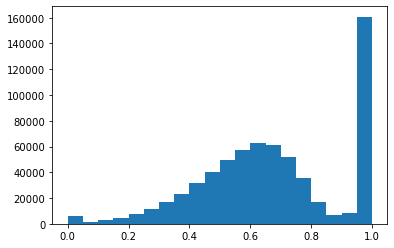

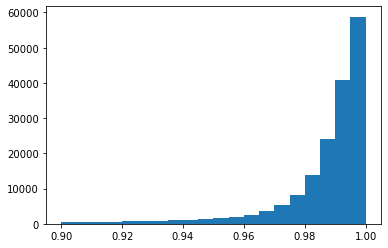

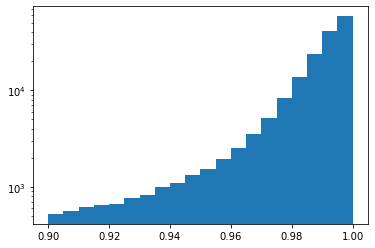

In [12]:
plt.hist(histatR2, range=(0, 1), bins = 20)
plt.show()

plt.hist(histatR2, range=(0.9, 1), bins = 20)
plt.show()

plt.hist(histatR2, range=(0.9, 1), bins = 20)
plt.yscale('log')
plt.show()

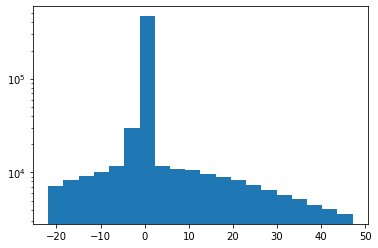

In [13]:
plt.hist(histatSRES, range=(np.percentile( histatSRES, 5), np.percentile( histatSRES, 95)), bins = 20)
plt.yscale('log')
plt.show()

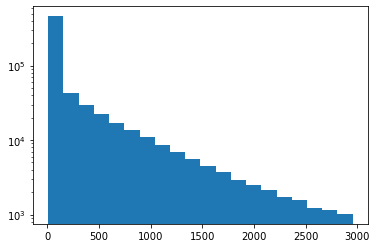

In [14]:
plt.hist(histatSSRES, range=(np.percentile( histatSSRES, 5), np.percentile( histatSSRES, 95)), bins = 20)
plt.yscale('log')
plt.show()

In [15]:
# Constant cuts
noise_bound = 0
zmax = 510
hienergybound = 2 # Events with double the median energy are excluded as possible Kr events

In [16]:
# Choose your analysis parameters:
# histat_events_energy_subtracted = histat_events_energy_subtracted_pre
# r2cut = 0.98
# histatZ = histat_Zgauss

## Check XYZ distributions

Peak range = -41.1 , 1899.8
Selected percentage = 11.0 %


/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:39: RuntimeWarning: invalid value encountered in true_divide


Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 10.8
200000 / 595249
Est remaining = 8.5
300000 / 595249
Est remaining = 6.4
400000 / 595249
Est remaining = 4.3
500000 / 595249
Est remaining = 2.2


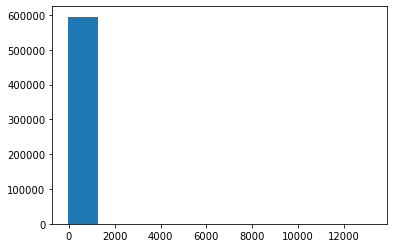

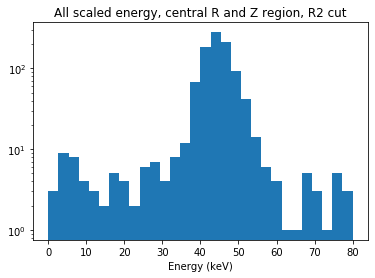

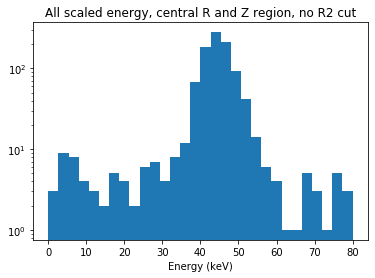

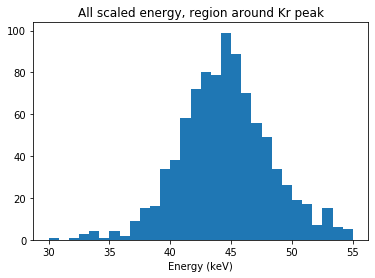

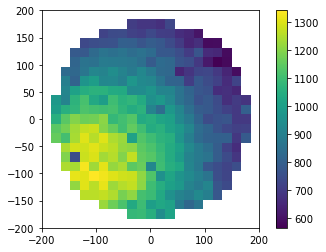

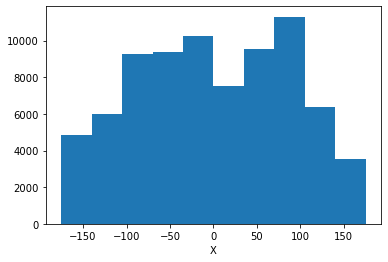

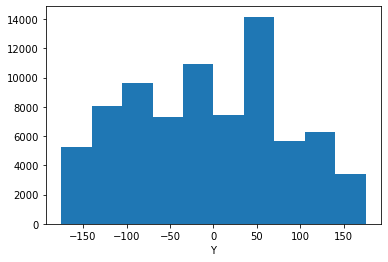

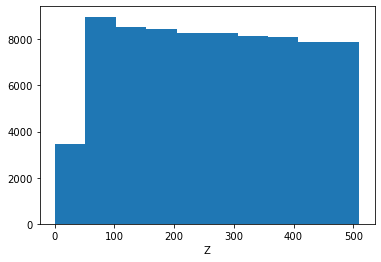

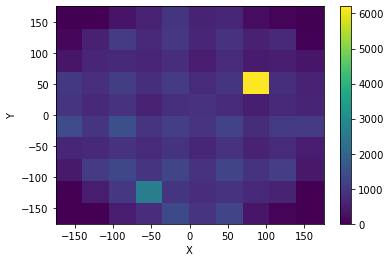

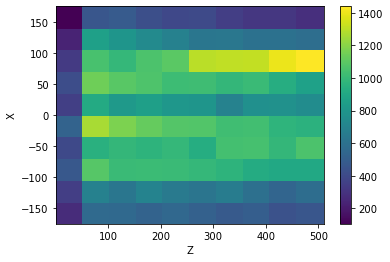

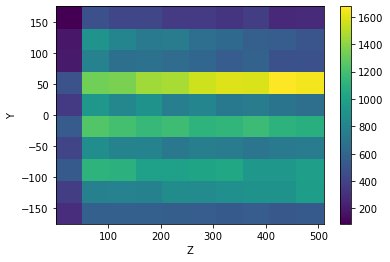

In [17]:
r2cut = 0.9
histatZ = histat_Zgauss
r2mask = histatR2 > r2cut
zmask = (histatZ > 0) & (histatZ < zmax)
rmask = histatX**2 + histatY**2 < 180**2
r2ZRnoisemask = r2mask & zmask & rmask # & (histat_events_energy_subtracted_pre > noise_bound)
hienergymask = histat_events_energy_subtracted_pre < hienergybound * np.percentile(histat_events_energy_subtracted_pre[r2ZRnoisemask], 50)
r2ZRhinoisemask = r2ZRnoisemask & hienergymask

med = np.median(histat_events_energy_subtracted_pre[r2ZRhinoisemask])
frac = 0.6827
lowcut = 0.5 - frac / 2
hicut = 0.5 + frac / 2
lft = med - 3 * (med - np.percentile(histat_events_energy_subtracted_pre[r2ZRhinoisemask], 100 * lowcut))
rgt = med + 3 * (np.percentile(histat_events_energy_subtracted_pre[r2ZRhinoisemask], 100 * hicut) - med)
print('Peak range =', round(lft,1),',', round(rgt,1))
histat_selfmask = r2ZRhinoisemask & (histat_events_energy_subtracted_pre > lft) & (histat_events_energy_subtracted_pre < rgt)
print('Selected percentage =', round(100*np.sum(histat_selfmask)/len(histat_selfmask),1), '%')

# Create own correction map
nbins = 23
clim = 200
dbin = 2 * clim / nbins
coord_range = np.linspace(-clim, clim, nbins + 1)
coord_bins = np.vstack((coord_range[:-1], coord_range[1:])).T

energy_sum = np.zeros((len(coord_bins),len(coord_bins)))
events_sum = np.zeros((len(coord_bins),len(coord_bins)))
for ix in range(len(coord_bins)):
    for iy in range(len(coord_bins)):
        xbin = coord_bins[ix]
        ybin = coord_bins[iy]
        xmask = (histatX > xbin[0]) & (histatX <= xbin[1])
        ymask = (histatY > ybin[0]) & (histatY <= ybin[1])
        xymask = xmask & ymask
        events_sum[ix][iy] = np.sum(xymask & histat_selfmask)
        energy_sum[ix][iy] = np.sum(histat_events_energy_subtracted_pre[xymask & histat_selfmask])

energy_xy = energy_sum / events_sum
energy_xy_bounds = ((-200, 200), (-200, 200))

# Apply the correction
histat_nomask = (histatX > energy_xy_bounds[0][0]) & (histatX < energy_xy_bounds[0][1]) & (histatY > energy_xy_bounds[1][0]) & (histatY < energy_xy_bounds[1][1])
histat_all_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_nomask, energies = histat_events_energy_subtracted_pre, xvals = histatX, yvals = histatY, vocal = True)
histat_all_scaled_energy *= 41.5



# Final cut spectra
histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
plt.title('All scaled energy, central R and Z region, R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
plt.title('All scaled energy, central R and Z region, no R2 cut')
plt.xlabel('Energy (keV)')
plt.yscale('log')
plt.show()

plt.hist(histat_all_scaled_energy[histat_center_mask], range = (30, 55), bins = 30)
plt.title('All scaled energy, region around Kr peak')
plt.xlabel('Energy (keV)')
plt.show()


plt.imshow(energy_xy, extent=[-200, 200, -200, 200], origin = 'lower')
plt.colorbar()
plt.show()


plt.hist(histatX[histat_selfmask])
plt.xlabel('X')
plt.show()

plt.hist(histatY[histat_selfmask])
plt.xlabel('Y')
plt.show()

plt.hist(histatZ[histat_selfmask])
plt.xlabel('Z')
plt.show()

h = plt.hist2d(histatX[histat_selfmask], histatY[histat_selfmask])
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar(h[3])
plt.show()

h = plt.hist2d(histatZ[histat_selfmask], histatX[histat_selfmask])
plt.xlabel('Z')
plt.ylabel('X')
plt.colorbar(h[3])
plt.show()

h = plt.hist2d(histatZ[histat_selfmask], histatY[histat_selfmask])
plt.xlabel('Z')
plt.ylabel('Y')
plt.colorbar(h[3])
plt.show()

In [18]:
def check_resolution(histatZ, histat_events_energy_subtracted, r2cut):

    # Create masks
    r2mask = histatR2 > r2cut
    zmask = (histatZ > 0) & (histatZ < zmax)
    rmask = histatX**2 + histatY**2 < 180**2
    r2ZRnoisemask = r2mask & (histat_events_energy_subtracted > noise_bound) & zmask & rmask
    hienergymask = histat_events_energy_subtracted < hienergybound * np.percentile(histat_events_energy_subtracted[r2ZRnoisemask], 50)
    r2ZRhinoisemask = r2ZRnoisemask & hienergymask

    # Set peak range
    med = np.median(histat_events_energy_subtracted[r2ZRhinoisemask])
    frac = 0.6827
    lowcut = 0.5 - frac / 2
    hicut = 0.5 + frac / 2
    lft = med - 3 * (med - np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 100 * lowcut))
    rgt = med + 3 * (np.percentile(histat_events_energy_subtracted[r2ZRhinoisemask], 100 * hicut) - med)
    print('Peak range =', round(lft,1),',', round(rgt,1))
    histat_selfmask = r2ZRhinoisemask & (histat_events_energy_subtracted > lft) & (histat_events_energy_subtracted < rgt)
    print('Selected percentage =', round(100*np.sum(histat_selfmask)/len(histat_selfmask),1), '\%')
    
    # Plot spectra after applying various cuts
    plt.hist(histat_events_energy_subtracted, bins = 25)
    plt.yscale('log')
    plt.title('Full spectrum')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted, range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask], range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max, with R2 cut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(0, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Spectrum up to Kr max, with R2 cut, Rcut, Zcut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[r2mask & rmask & zmask], range=(lft, rgt), bins = 25)
    plt.yscale('log')
    plt.title('Selected Kr events, with R2 cut, Rcut, Zcut')
    plt.xlabel('Energy (pes)')
    plt.show()

    plt.hist(histat_events_energy_subtracted[histat_selfmask], bins = 25)
    plt.title('Selected Kr events, with R2 cut, Rcut, Zcut; linear scale')
    plt.xlabel('Energy (pes)')
    plt.show()

    # Noise spectrum
    plt.hist(histat_events_energy_subtracted, range=(0, 500), bins = 25)
    plt.title('Noise spectrum')
    plt.yscale('log')
    plt.show()

    plt.hist(histat_events_energy_subtracted[~r2mask], range=(0, 500), bins = 25)
    plt.title('Noise spectrum, bad R2')
    plt.yscale('log')
    plt.show()

    # Create own correction map
    nbins = 23
    clim = 200
    dbin = 2 * clim / nbins
    coord_range = np.linspace(-clim, clim, nbins + 1)
    coord_bins = np.vstack((coord_range[:-1], coord_range[1:])).T

    energy_sum = np.zeros((len(coord_bins),len(coord_bins)))
    events_sum = np.zeros((len(coord_bins),len(coord_bins)))
    for ix in range(len(coord_bins)):
        for iy in range(len(coord_bins)):
            xbin = coord_bins[ix]
            ybin = coord_bins[iy]
            xmask = (histatX > xbin[0]) & (histatX <= xbin[1])
            ymask = (histatY > ybin[0]) & (histatY <= ybin[1])
            xymask = xmask & ymask
            events_sum[ix][iy] = np.sum(xymask & histat_selfmask)
            energy_sum[ix][iy] = np.sum(histat_events_energy_subtracted[xymask & histat_selfmask])

    energy_xy = energy_sum / events_sum
    energy_xy_bounds = ((-200, 200), (-200, 200))

    plt.imshow(energy_xy, extent=[-200, 200, -200, 200], origin = 'lower')
    plt.colorbar()
    plt.show()

    map_out = './maps_from_maxsipm/map_'+runno+'.npy'

    with open(map_out, 'wb') as f:
        np.save(f, energy_xy)

    with open(map_out, 'rb') as f:
        test_readin_xy = np.load(f)

    plt.imshow(test_readin_xy, extent=[-200, 200, -200, 200], origin = 'lower')
    plt.colorbar()
    plt.show()

    # Apply the correction
    histat_nomask = (histatX > energy_xy_bounds[0][0]) & (histatX < energy_xy_bounds[0][1]) & (histatY > energy_xy_bounds[1][0]) & (histatY < energy_xy_bounds[1][1])
    histat_all_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_nomask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)
    histat_all_scaled_energy *= 41.5

    plt.hist(histat_all_scaled_energy, range = (0, 80), bins = 20)
    plt.title('All scaled energy')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    # Final cut spectra
    histat_center_mask = r2mask[histat_nomask] & (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
    plt.title('All scaled energy, central R and Z region, R2 mask')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    histat_center_mask = (histatX[histat_nomask]**2 + histatY[histat_nomask]**2 < 50**2) & (histatZ[histat_nomask] < 100)
    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (0, 80), bins = 30)
    plt.title('All scaled energy, central R and Z region, no R2 mask')
    plt.xlabel('Energy (keV)')
    plt.yscale('log')
    plt.show()

    plt.hist(histat_all_scaled_energy[histat_center_mask], range = (30, 55), bins = 30)
    plt.title('All scaled energy, region around Kr peak, R2 mask')
    plt.xlabel('Energy (keV)')
    plt.show()

    # r7472_scaled_energy = correct_energies(e0_7472, bounds_7472, umask = selfmask, ltmap = lt_7472)
    # r7472_res_vs_zr = fit_res_vs_zr(r7472_scaled_energy, e0_7472, bounds_7472, umask = selfmask)
    histat_scaled_energy = correct_energies(energy_xy, energy_xy_bounds, umask = histat_selfmask, energies = histat_events_energy_subtracted, xvals = histatX, yvals = histatY, vocal = True)

    histat_self_res_vs_zr = fit_res_vs_zr(histat_scaled_energy, energy_xy, energy_xy_bounds, umask = histat_selfmask, xvals = histatX, yvals = histatY, zvals = histatZ)
    plot_res_vs_zr(histat_self_res_vs_zr)
    print('All resolutions:', histat_self_res_vs_zr)
    
    return histat_self_res_vs_zr


================ CHECKING R2 CUT = 0.4 ================
Peak range = -239.6 , 1924.6
Selected percentage = 11.8 \%


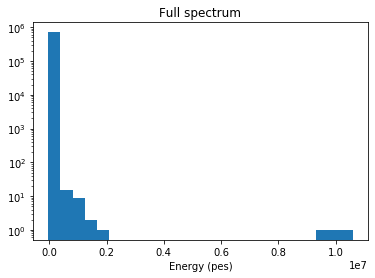

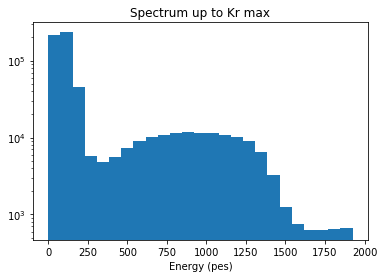

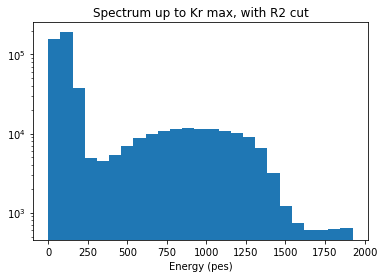

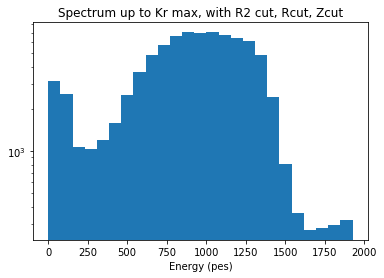

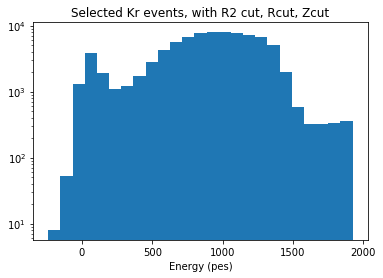

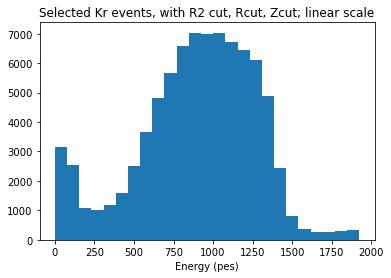

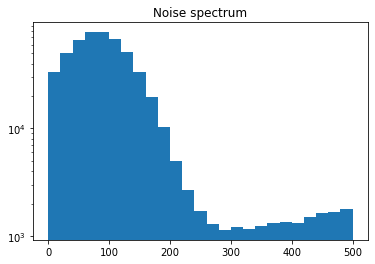

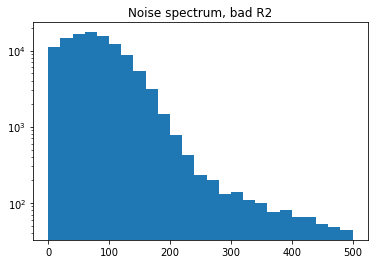

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


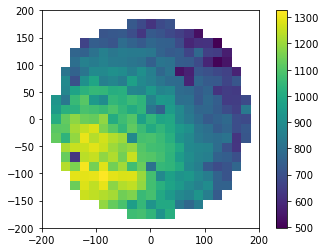

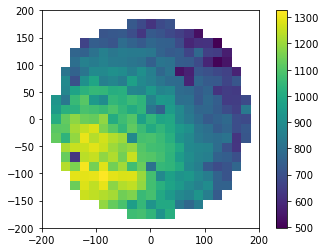

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 12.5
200000 / 595249
Est remaining = 9.3
300000 / 595249
Est remaining = 6.8
400000 / 595249
Est remaining = 4.6
500000 / 595249
Est remaining = 2.4


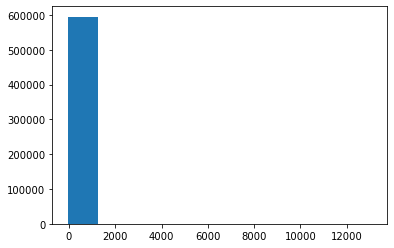

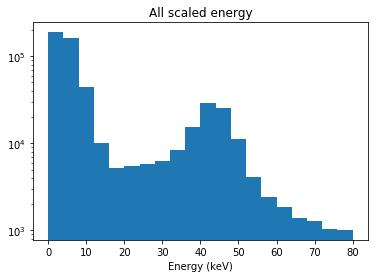

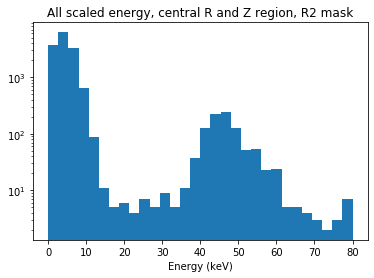

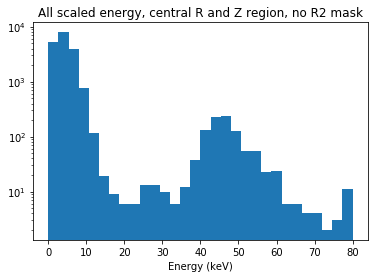

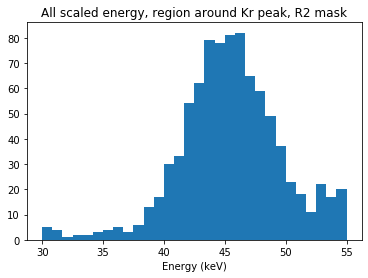

Correcting energies...
0 / 83769


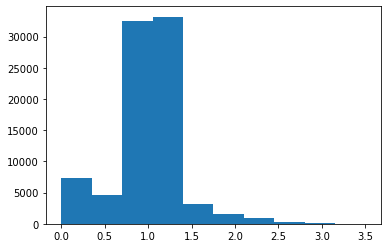

Fit a Gaussian with guess (A0, m0, s0) = (44.0, 1, 0.3339066632486161)


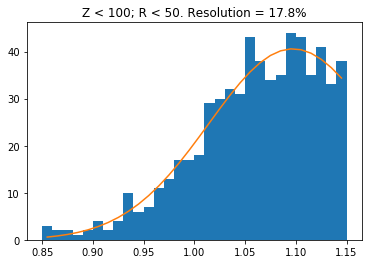

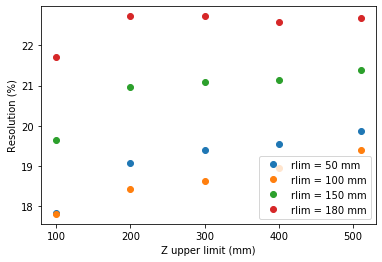

Innermost resolution =  17.83 %
Outermost resolution =  22.67 %
All resolutions: {100050: 17.834299648604297, 100100: 17.815383895165816, 100150: 19.65107948544676, 100180: 21.70378197545424, 200050: 19.073754048857907, 200100: 18.42983217693132, 200150: 20.963370148474876, 200180: 22.716520368764805, 300050: 19.397320380835335, 300100: 18.639381035338285, 300150: 21.09686439957451, 300180: 22.72056449988381, 400050: 19.557048355685875, 400100: 18.954294552349428, 400150: 21.150318842959194, 400180: 22.573302541288175, 510050: 19.871046316884765, 510100: 19.394724466924544, 510150: 21.393074688048774, 510180: 22.66622551502423}

================ CHECKING R2 CUT = 0.5 ================
Peak range = -212.7 , 1922.1
Selected percentage = 11.7 \%


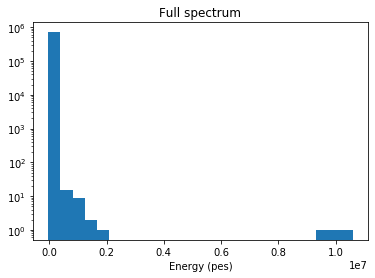

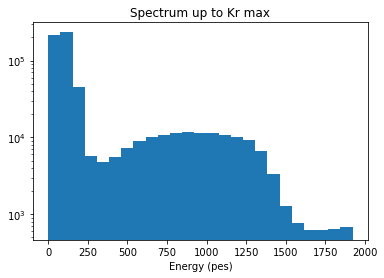

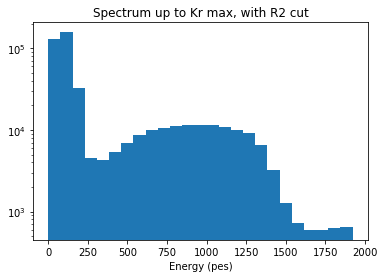

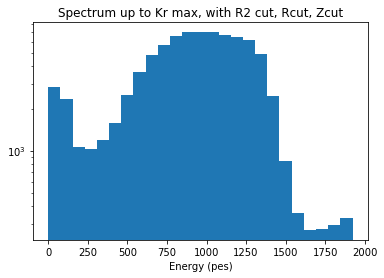

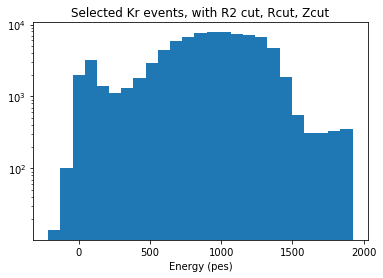

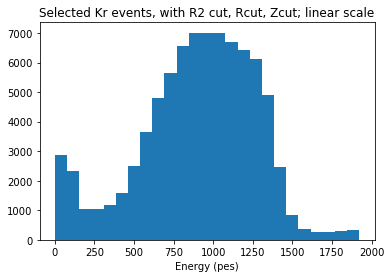

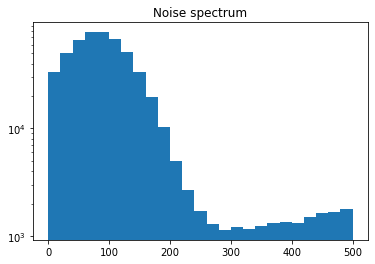

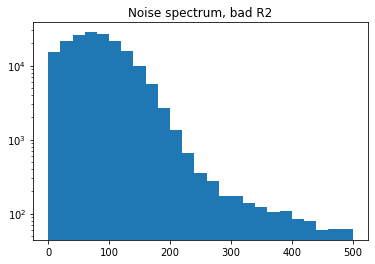

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


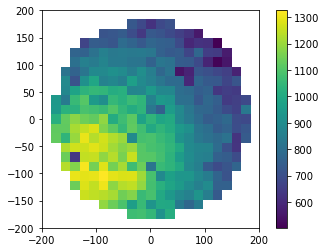

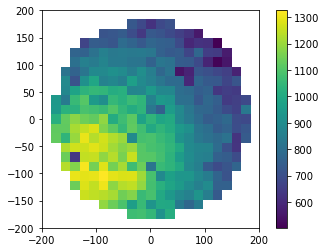

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 11.1
200000 / 595249
Est remaining = 9.2
300000 / 595249
Est remaining = 7.1
400000 / 595249
Est remaining = 4.7
500000 / 595249
Est remaining = 2.4


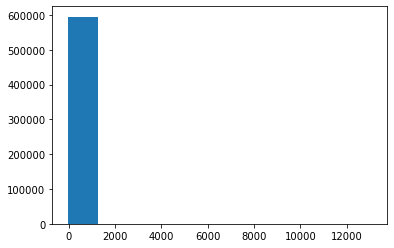

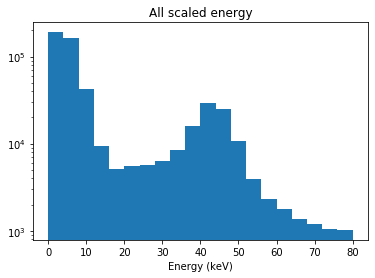

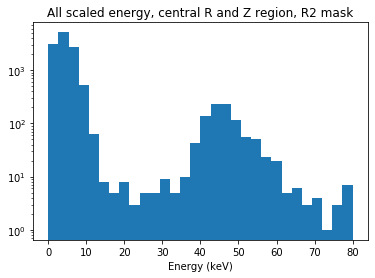

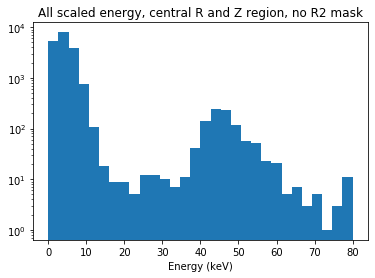

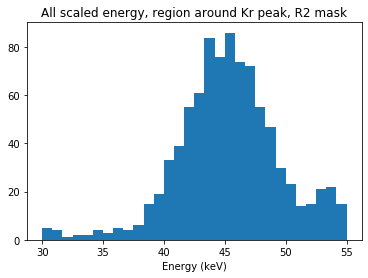

Correcting energies...
0 / 83224


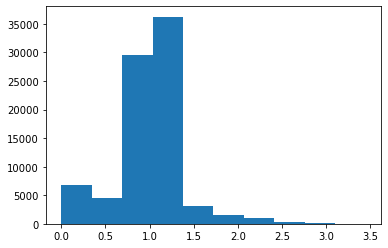

Fit a Gaussian with guess (A0, m0, s0) = (46.0, 1, 0.3181243486593616)


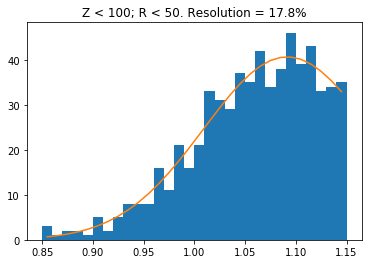

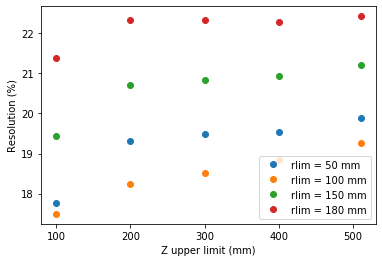

Innermost resolution =  17.76 %
Outermost resolution =  22.43 %
All resolutions: {100050: 17.76424262069109, 100100: 17.492909527940206, 100150: 19.4484186295974, 100180: 21.392367382796177, 200050: 19.304856991957084, 200100: 18.2427048560159, 200150: 20.707924993265685, 200180: 22.320313278383107, 300050: 19.49823225148497, 300100: 18.511591244445178, 300150: 20.824111853428537, 300180: 22.327084900948538, 400050: 19.542087854753024, 400100: 18.832920227986264, 400150: 20.933433708695418, 400180: 22.276444694976362, 510050: 19.892878823841162, 510100: 19.267430132987986, 510150: 21.214961252904125, 510180: 22.425971822426227}

================ CHECKING R2 CUT = 0.6 ================
Peak range = -174.2 , 1919.6
Selected percentage = 11.6 \%


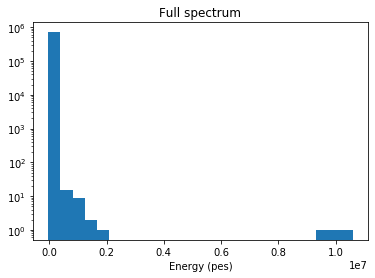

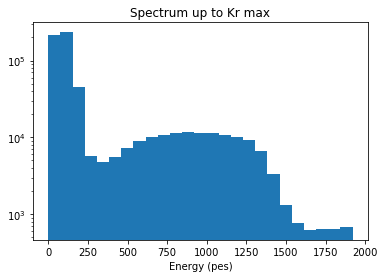

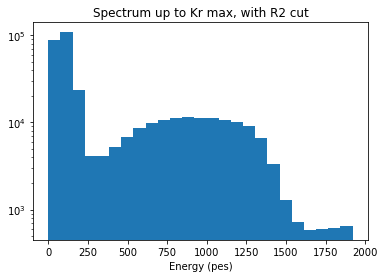

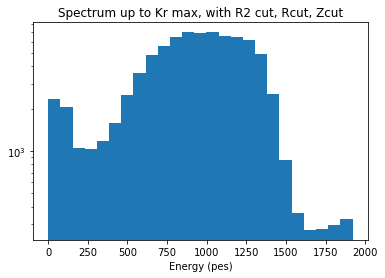

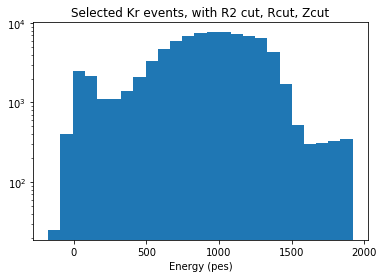

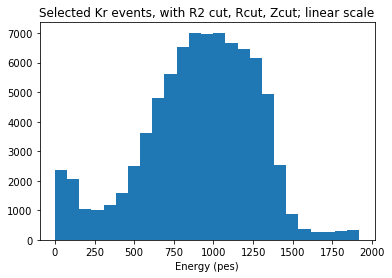

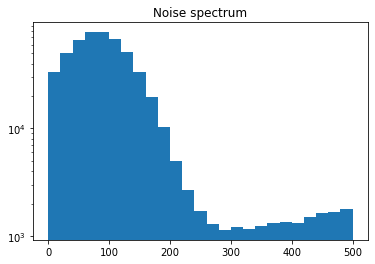

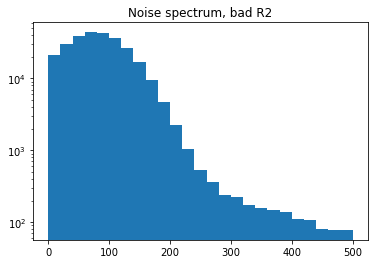

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


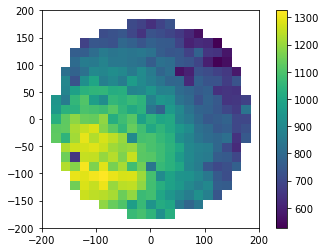

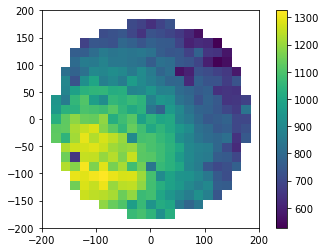

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 12.0
200000 / 595249
Est remaining = 9.4
300000 / 595249
Est remaining = 7.4
400000 / 595249
Est remaining = 4.9
500000 / 595249
Est remaining = 2.4


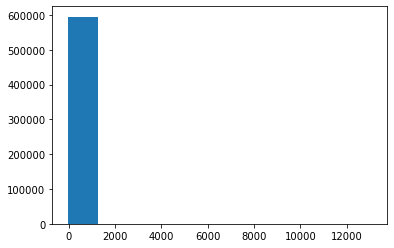

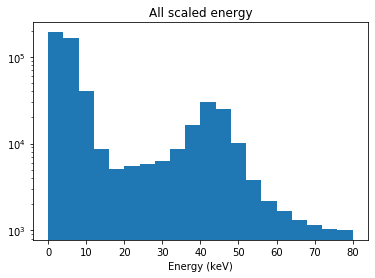

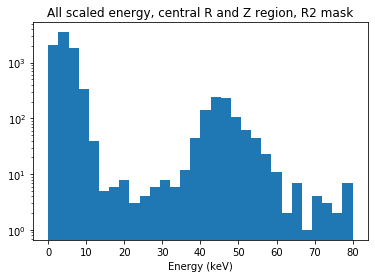

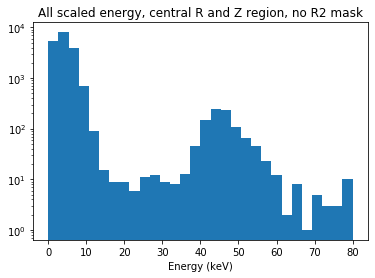

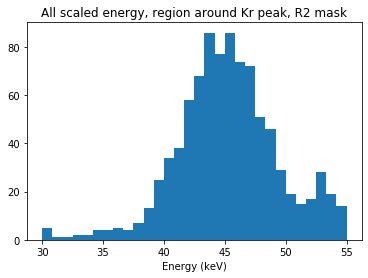

Correcting energies...
0 / 82374


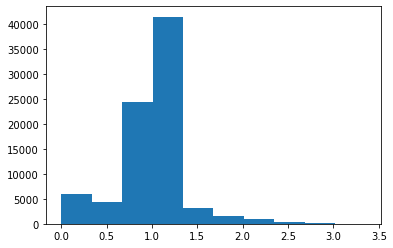

Fit a Gaussian with guess (A0, m0, s0) = (45.0, 1, 0.30196734797338354)


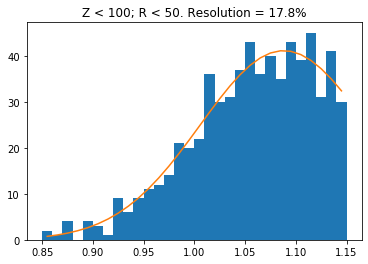

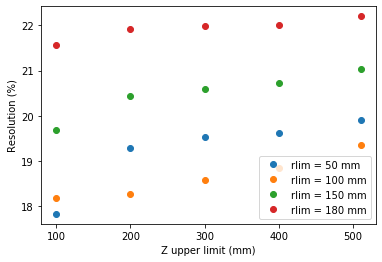

Innermost resolution =  17.83 %
Outermost resolution =  22.2 %
All resolutions: {100050: 17.829134560723297, 100100: 18.185713832746668, 100150: 19.687955878250772, 100180: 21.55813418110416, 200050: 19.280120712165314, 200100: 18.262204004823243, 200150: 20.428204650537875, 200180: 21.926439199024838, 300050: 19.533263938534876, 300100: 18.58826959508265, 300150: 20.590789376481816, 300180: 21.98236075037793, 400050: 19.613098804840135, 400100: 18.849820554859456, 400150: 20.73520131698914, 400180: 22.0112732084643, 510050: 19.912989762726387, 510100: 19.347951266075636, 510150: 21.03101794882138, 510180: 22.202702779486714}

================ CHECKING R2 CUT = 0.7 ================
Peak range = -119.7 , 1912.8
Selected percentage = 11.4 \%


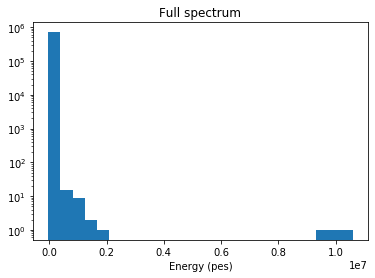

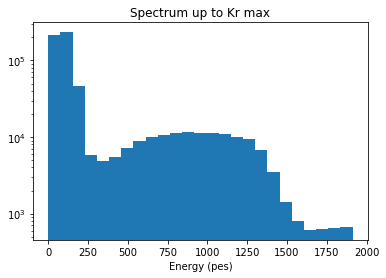

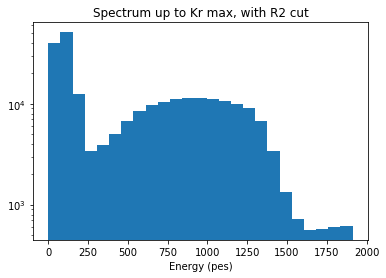

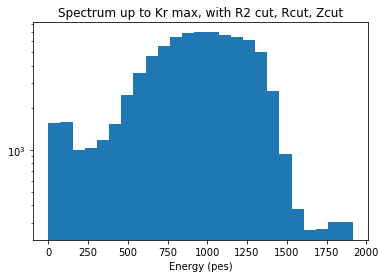

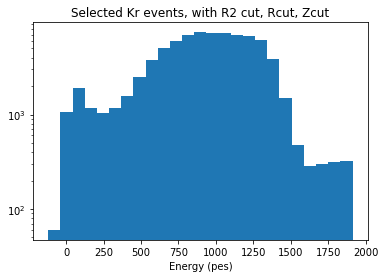

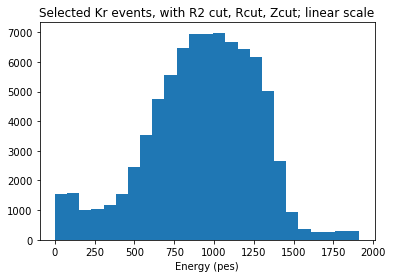

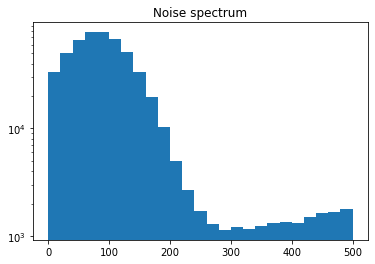

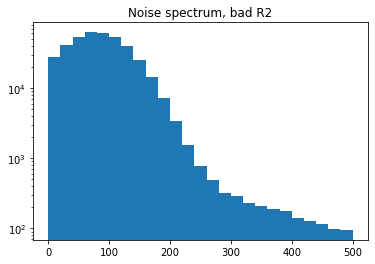

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


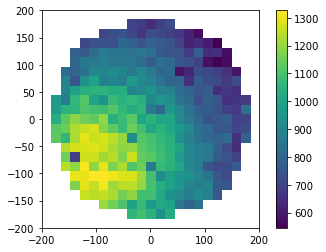

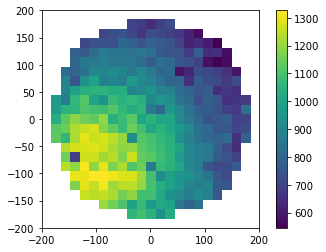

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 13.2
200000 / 595249
Est remaining = 10.1
300000 / 595249
Est remaining = 8.3
400000 / 595249
Est remaining = 6.0
500000 / 595249
Est remaining = 3.2


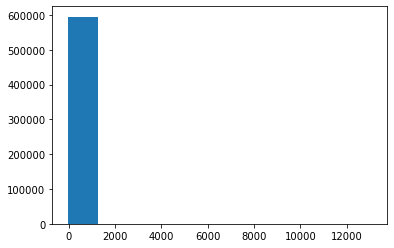

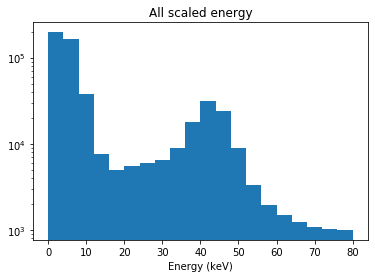

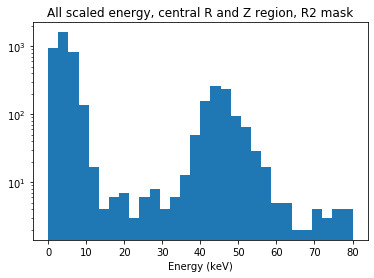

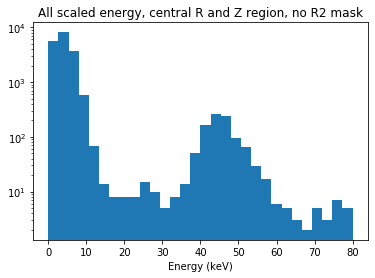

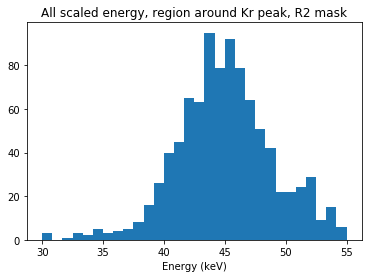

Correcting energies...
0 / 80974


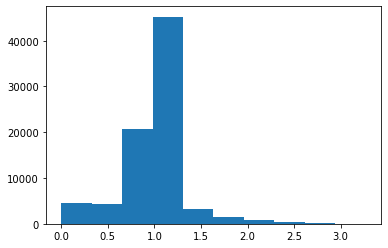

Fit a Gaussian with guess (A0, m0, s0) = (48.0, 1, 0.25970642540512723)


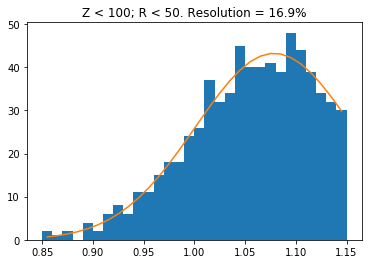

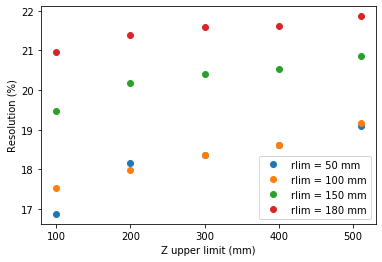

Innermost resolution =  16.88 %
Outermost resolution =  21.86 %
All resolutions: {100050: 16.877675058439664, 100100: 17.539624192950377, 100150: 19.465274763750152, 100180: 20.96455184290373, 200050: 18.165401522478497, 200100: 17.976163330051374, 200150: 20.177404035587116, 200180: 21.39649770048497, 300050: 18.37125336493636, 300100: 18.35047662886724, 300150: 20.40507431580352, 300180: 21.583082703249215, 400050: 18.611027919357117, 400100: 18.62545577998462, 400150: 20.543170222799567, 400180: 21.61997269431292, 510050: 19.0976322135281, 510100: 19.176086026419465, 510150: 20.858309996370313, 510180: 21.861359208316347}

================ CHECKING R2 CUT = 0.8 ================
Peak range = -71.3 , 1906.7
Selected percentage = 11.2 \%


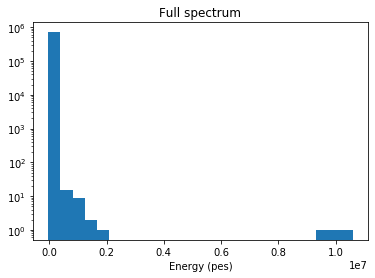

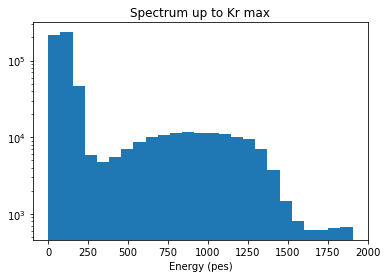

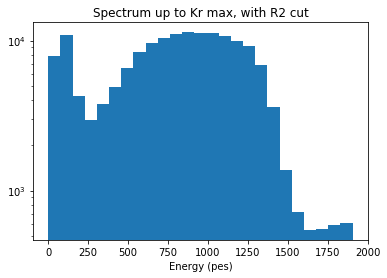

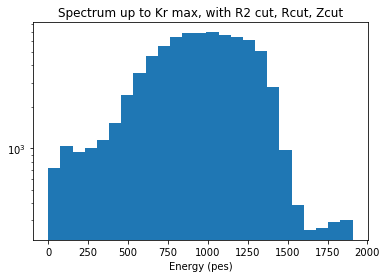

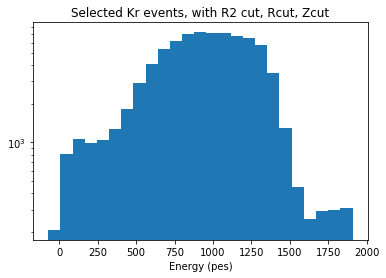

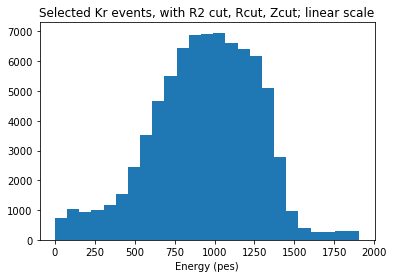

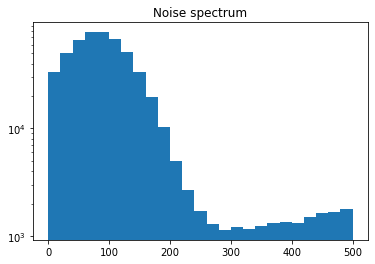

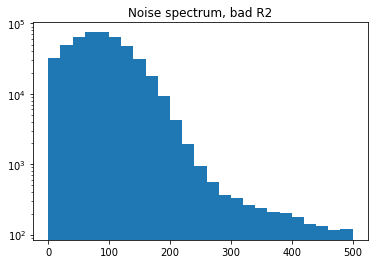

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


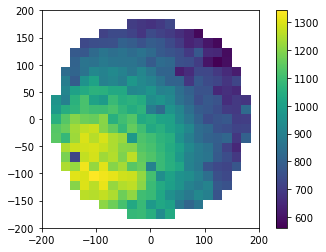

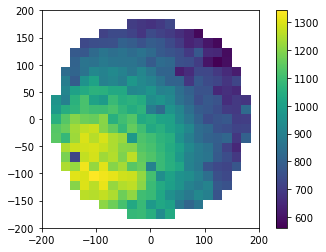

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 19.7
200000 / 595249
Est remaining = 18.8
300000 / 595249
Est remaining = 14.6
400000 / 595249
Est remaining = 9.3
500000 / 595249
Est remaining = 4.7


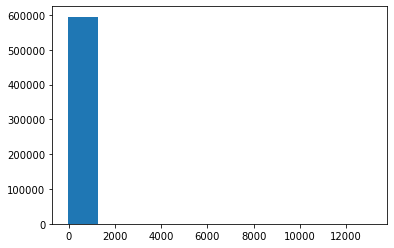

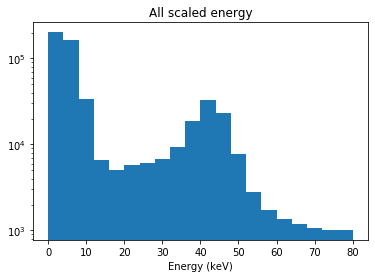

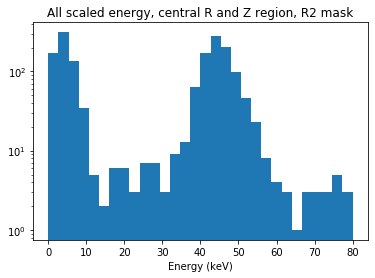

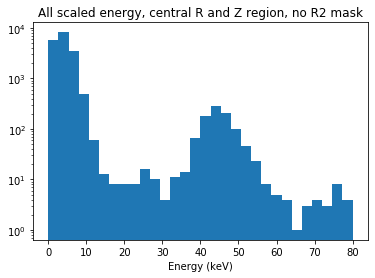

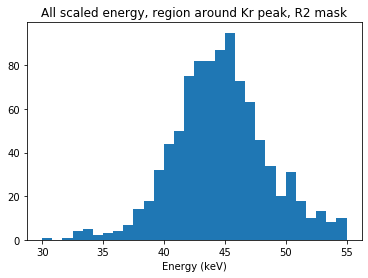

Correcting energies...
0 / 79280


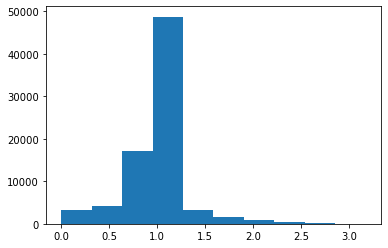

Fit a Gaussian with guess (A0, m0, s0) = (51.0, 1, 0.22641708434589608)


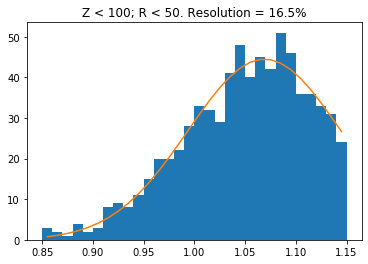

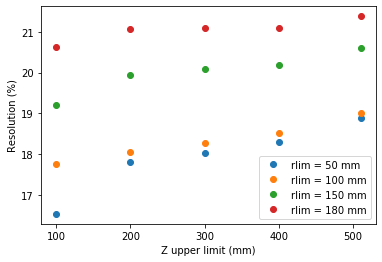

Innermost resolution =  16.53 %
Outermost resolution =  21.38 %
All resolutions: {100050: 16.53212585305112, 100100: 17.759941044779804, 100150: 19.208769176087777, 100180: 20.632309242695857, 200050: 17.817082228170683, 200100: 18.043787651188673, 200150: 19.942151912398344, 200180: 21.05749375492052, 300050: 18.036156574285332, 300100: 18.272258825492482, 300150: 20.089120474760445, 300180: 21.09011073447822, 400050: 18.29900332384998, 400100: 18.51780217980586, 400150: 20.19108633728388, 400180: 21.084935813406013, 510050: 18.880056968774173, 510100: 19.01973138138574, 510150: 20.59082308662672, 510180: 21.381810483748428}

================ CHECKING R2 CUT = 0.9 ================
Peak range = -37.1 , 1899.1
Selected percentage = 11.0 \%


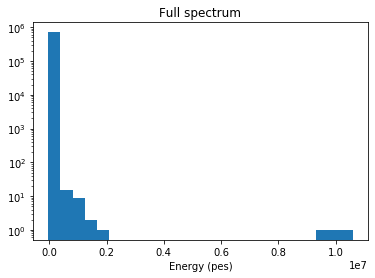

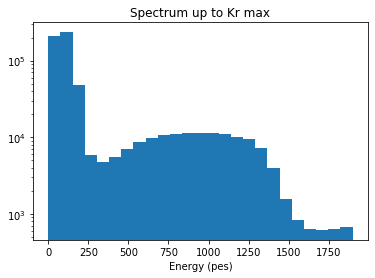

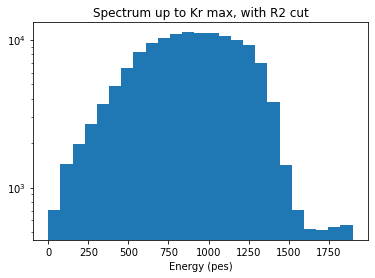

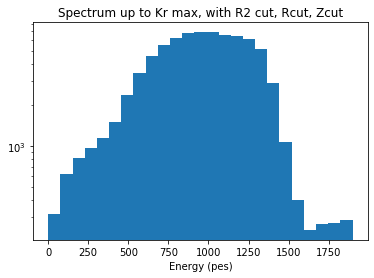

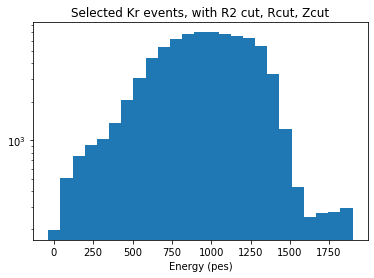

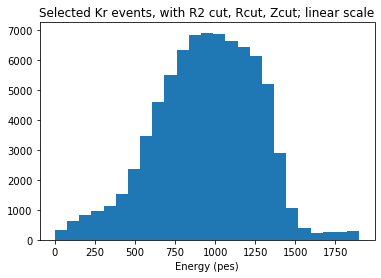

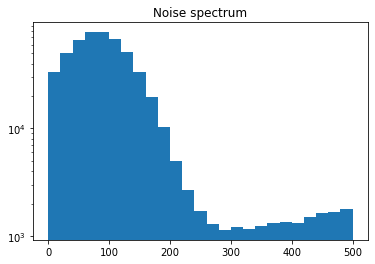

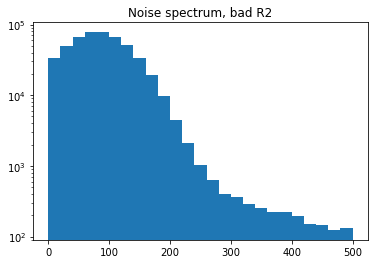

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


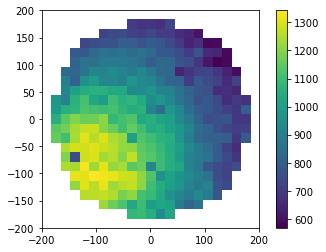

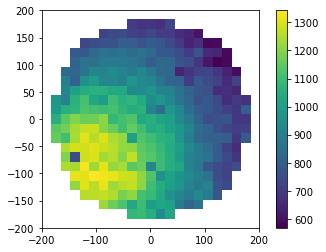

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 18.8
200000 / 595249
Est remaining = 16.1
300000 / 595249
Est remaining = 12.9
400000 / 595249
Est remaining = 8.4
500000 / 595249
Est remaining = 4.1


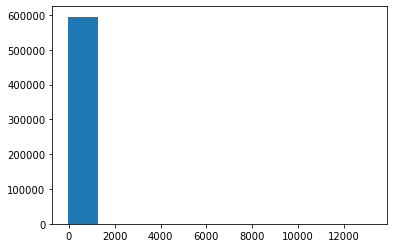

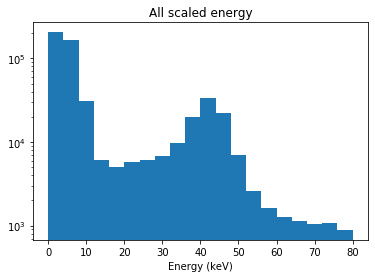

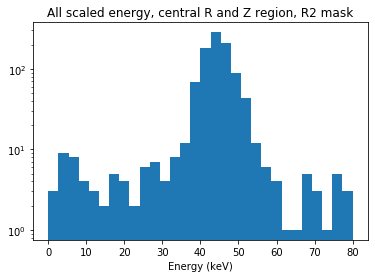

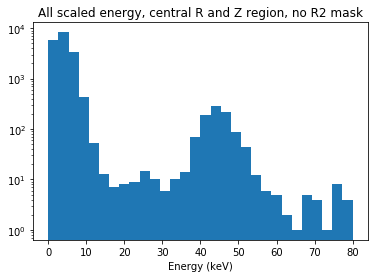

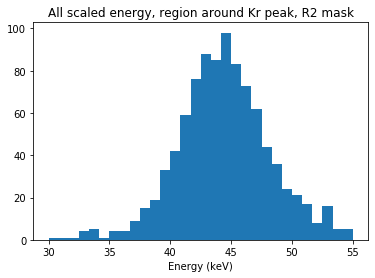

Correcting energies...
0 / 77969


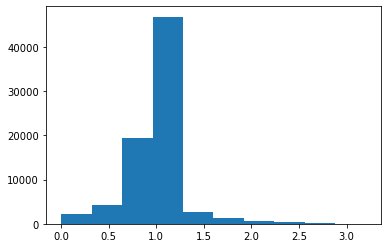

Fit a Gaussian with guess (A0, m0, s0) = (54.0, 1, 0.1858156597504021)


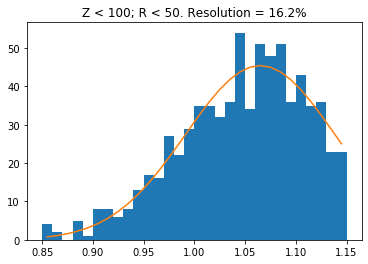

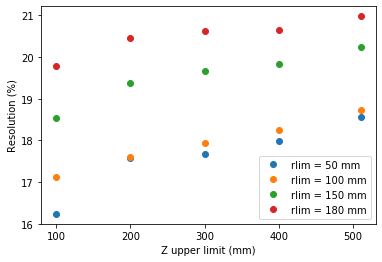

Innermost resolution =  16.24 %
Outermost resolution =  20.98 %
All resolutions: {100050: 16.237121746589033, 100100: 17.131023599784104, 100150: 18.544780384675484, 100180: 19.795384859059123, 200050: 17.58719333587108, 200100: 17.611237778323435, 200150: 19.376577910880215, 200180: 20.457835085006977, 300050: 17.686067747004273, 300100: 17.947196668967212, 300150: 19.67436573542728, 300180: 20.631646903279194, 400050: 17.98642460150309, 400100: 18.243558011487682, 400150: 19.82417765645557, 400180: 20.653702963782823, 510050: 18.572212929794123, 510100: 18.734171946295096, 510150: 20.24136690161987, 510180: 20.979803997329014}

================ CHECKING R2 CUT = 0.92 ================
Peak range = -29.5 , 1895.7
Selected percentage = 10.9 \%


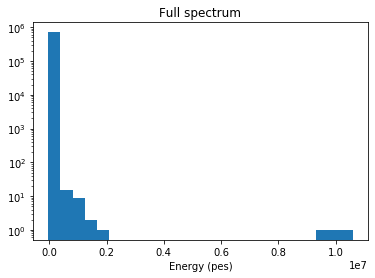

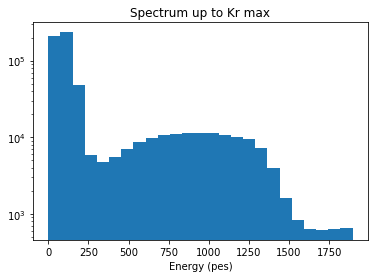

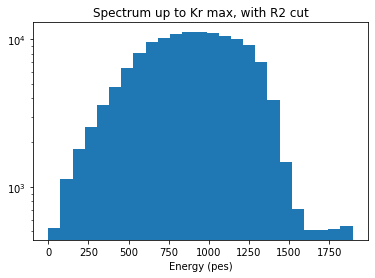

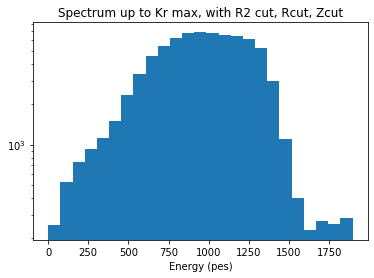

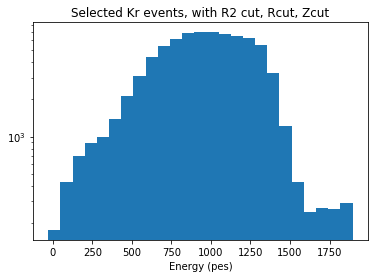

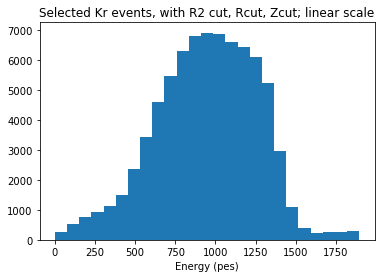

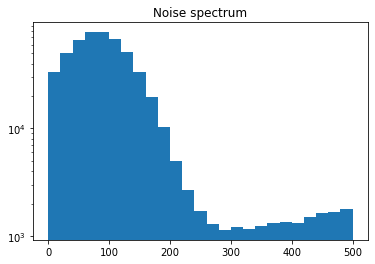

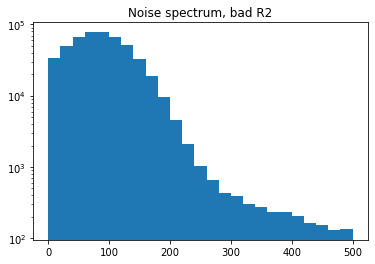

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


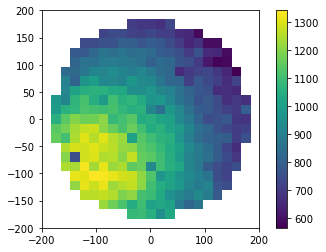

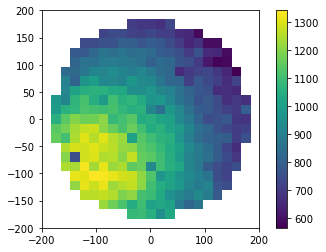

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 18.7
200000 / 595249
Est remaining = 14.6
300000 / 595249
Est remaining = 10.8
400000 / 595249
Est remaining = 7.2
500000 / 595249
Est remaining = 3.5


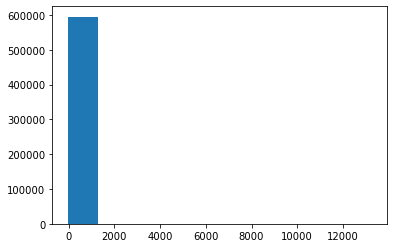

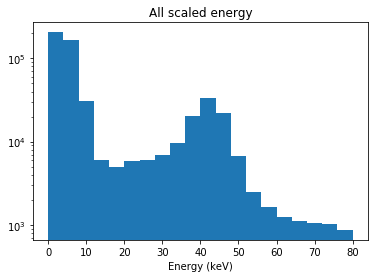

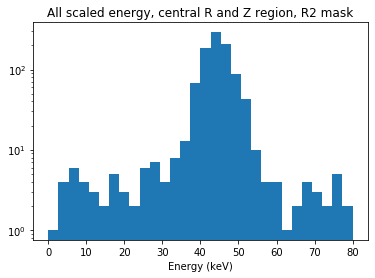

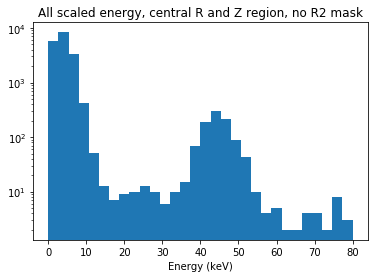

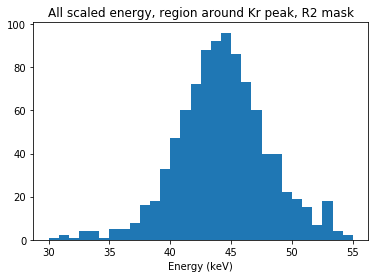

Correcting energies...
0 / 77570


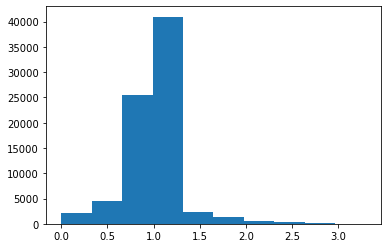

Fit a Gaussian with guess (A0, m0, s0) = (50.0, 1, 0.17853700208995096)


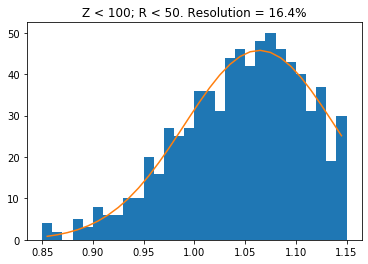

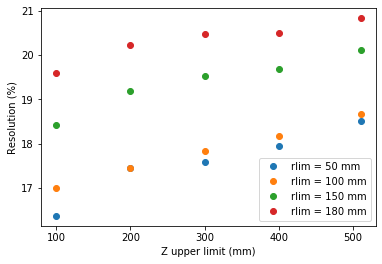

Innermost resolution =  16.36 %
Outermost resolution =  20.83 %
All resolutions: {100050: 16.364821853176707, 100100: 16.98891634731508, 100150: 18.415309958100096, 100180: 19.58716711586455, 200050: 17.454232314255776, 200100: 17.452617574740046, 200150: 19.191382733362857, 200180: 20.238432065496074, 300050: 17.590475434258384, 300100: 17.835349147367655, 300150: 19.526946352625952, 300180: 20.46620918452804, 400050: 17.943059520708946, 400100: 18.174456534687028, 400150: 19.692243650892344, 400180: 20.496320761336165, 510050: 18.49960428359212, 510100: 18.659730425400433, 510150: 20.121092371505892, 510180: 20.831811205381214}

================ CHECKING R2 CUT = 0.94 ================
Peak range = -14.5 , 1892.5
Selected percentage = 10.8 \%


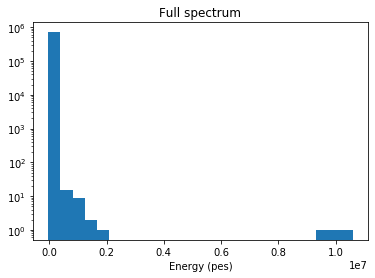

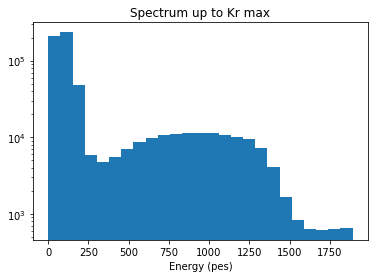

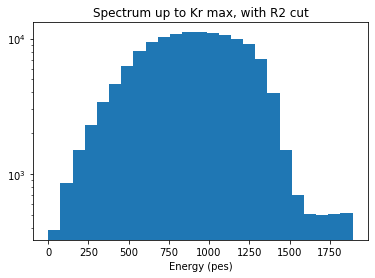

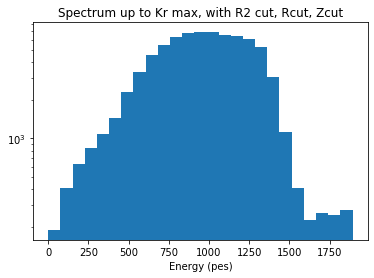

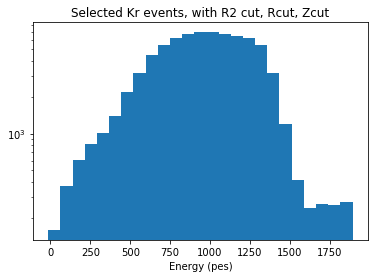

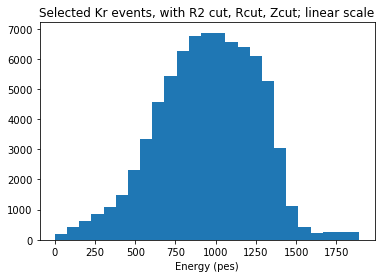

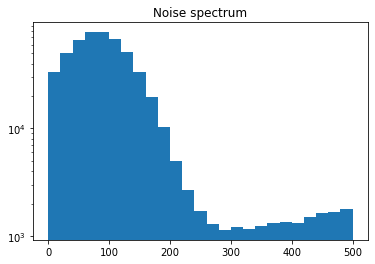

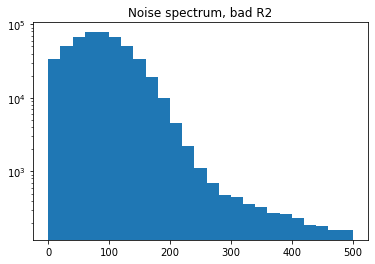

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


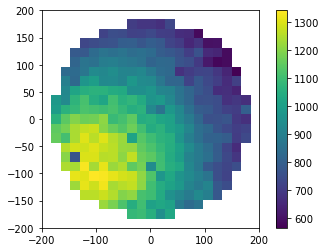

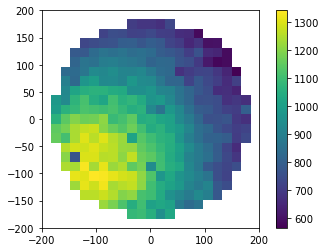

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 22.4
200000 / 595249
Est remaining = 17.0
300000 / 595249
Est remaining = 12.9
400000 / 595249
Est remaining = 8.5
500000 / 595249
Est remaining = 4.1


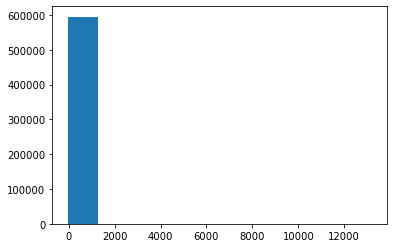

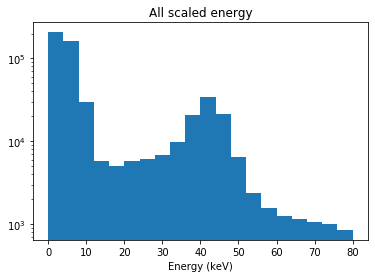

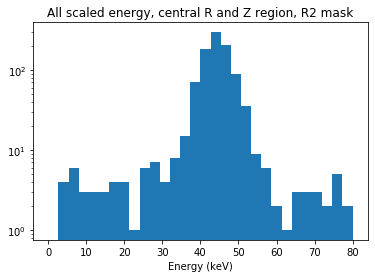

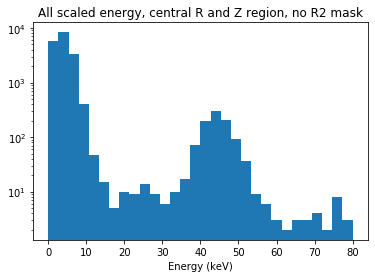

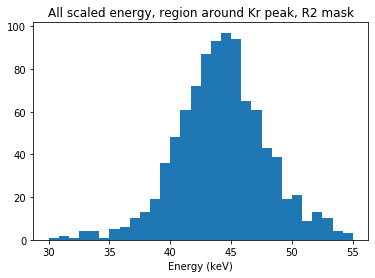

Correcting energies...
0 / 76993


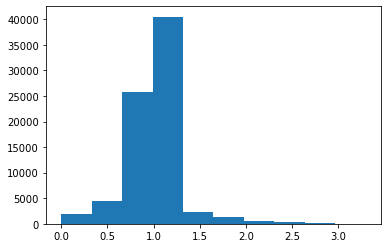

Fit a Gaussian with guess (A0, m0, s0) = (52.0, 1, 0.17534042833228758)


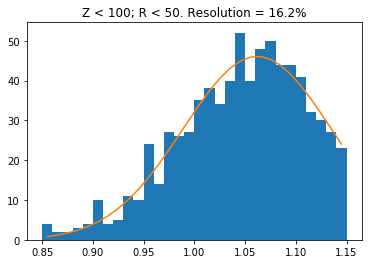

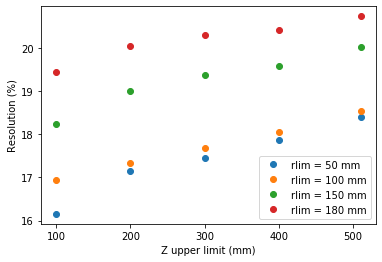

Innermost resolution =  16.15 %
Outermost resolution =  20.73 %
All resolutions: {100050: 16.153108689250857, 100100: 16.948048915317766, 100150: 18.239781700051076, 100180: 19.442588179911027, 200050: 17.14090702533725, 200100: 17.326866023001138, 200150: 18.990344516694382, 200180: 20.03766808868632, 300050: 17.447546273935192, 300100: 17.674968081386698, 300150: 19.35981818925153, 300180: 20.30088178252437, 400050: 17.86701660297853, 400100: 18.045997207620875, 400150: 19.58204479092158, 400180: 20.403627861571277, 510050: 18.38768761318687, 510100: 18.527706109758974, 510150: 20.007257280634853, 510180: 20.72863133206131}

================ CHECKING R2 CUT = 0.96 ================
Peak range = 11.0 , 1886.1
Selected percentage = 10.7 \%


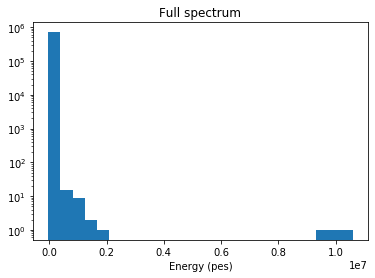

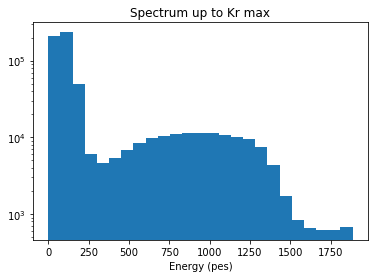

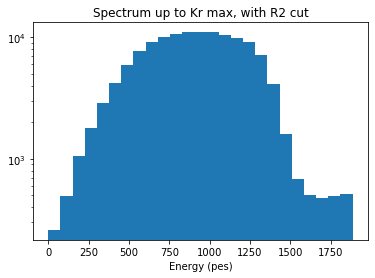

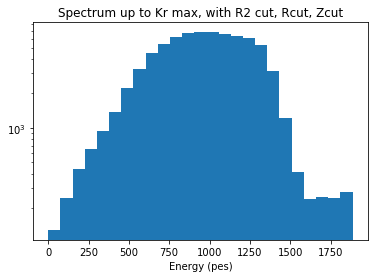

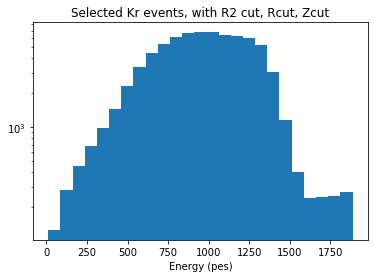

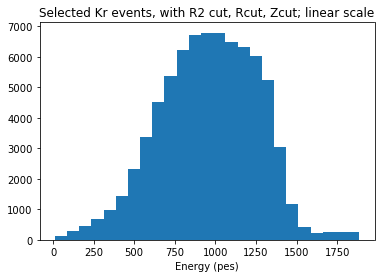

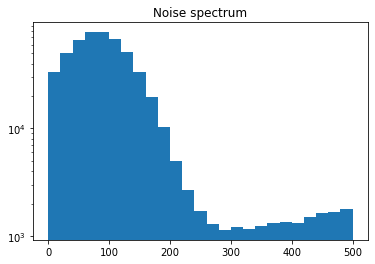

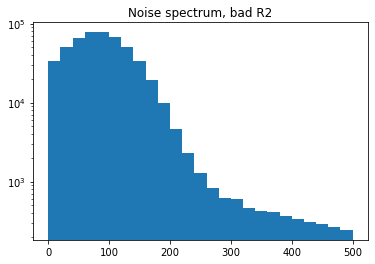

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


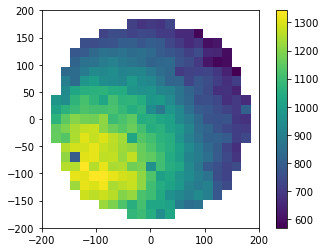

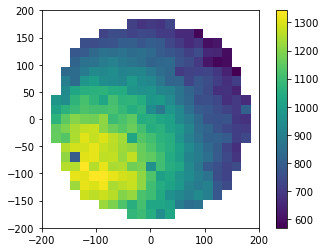

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 25.8
200000 / 595249
Est remaining = 19.2
300000 / 595249
Est remaining = 14.5
400000 / 595249
Est remaining = 9.6
500000 / 595249
Est remaining = 4.6


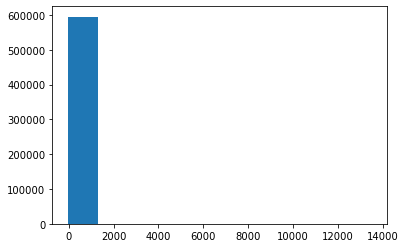

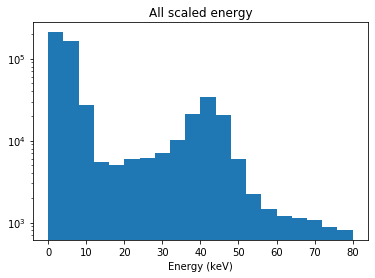

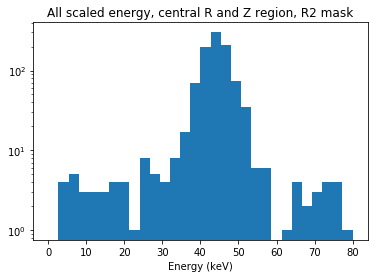

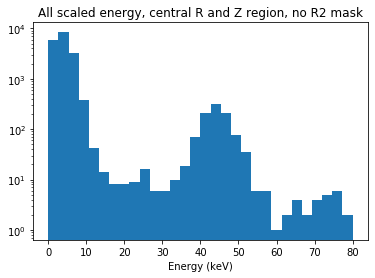

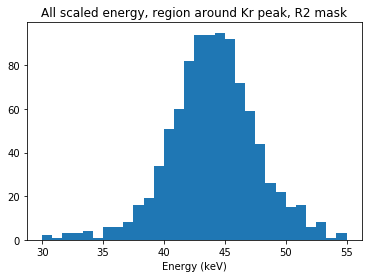

Correcting energies...
0 / 75750


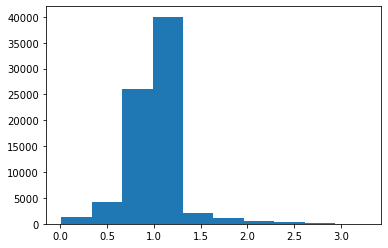

Fit a Gaussian with guess (A0, m0, s0) = (54.0, 1, 0.17090273450534574)


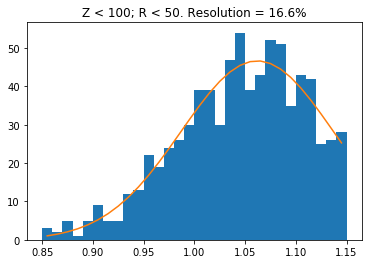

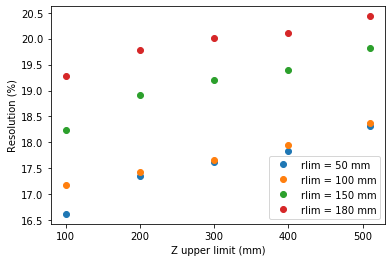

Innermost resolution =  16.62 %
Outermost resolution =  20.43 %
All resolutions: {100050: 16.622988453595212, 100100: 17.180934342570747, 100150: 18.246666788152535, 100180: 19.28815288798778, 200050: 17.34825603628192, 200100: 17.424406762333223, 200150: 18.91477628748251, 200180: 19.778913827571944, 300050: 17.614470015205537, 300100: 17.66928112928229, 300150: 19.21149078319704, 300180: 20.019266436746243, 400050: 17.83946361341865, 400100: 17.948541739520415, 400150: 19.393238829248066, 400180: 20.109347586599057, 510050: 18.325035833331135, 510100: 18.379271066691548, 510150: 19.811782299951382, 510180: 20.43159677923714}

================ CHECKING R2 CUT = 0.98 ================
Peak range = 78.0 , 1871.7
Selected percentage = 9.9 \%


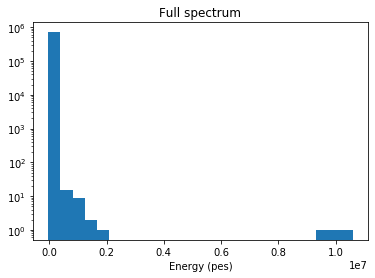

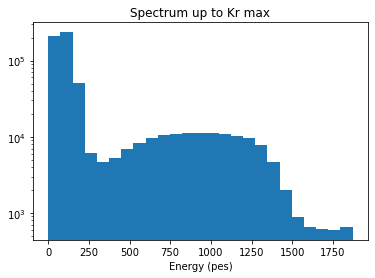

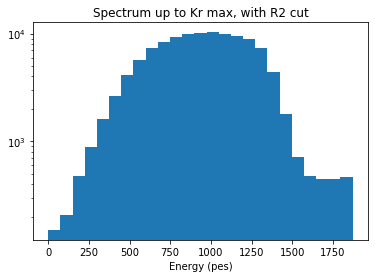

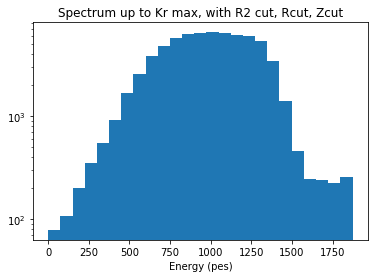

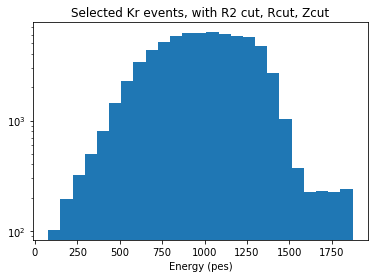

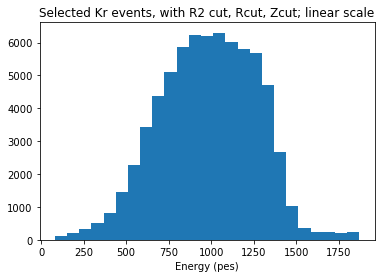

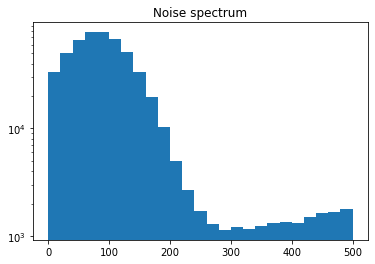

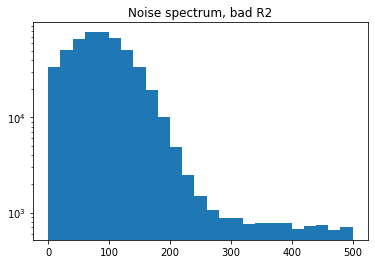

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


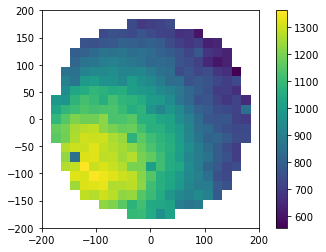

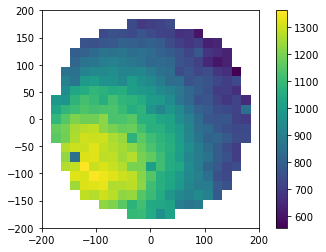

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 21.9
200000 / 595249
Est remaining = 19.0
300000 / 595249
Est remaining = 13.8
400000 / 595249
Est remaining = 9.2
500000 / 595249
Est remaining = 4.4


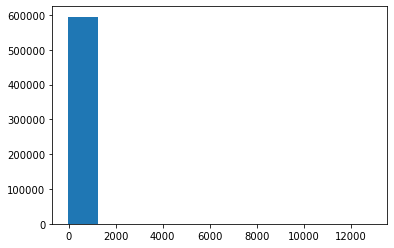

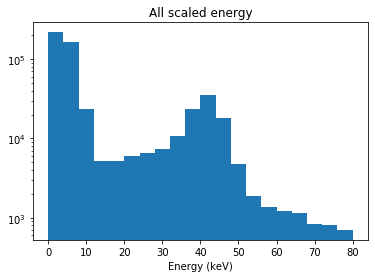

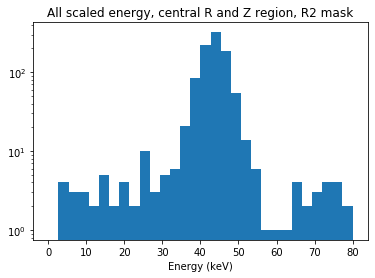

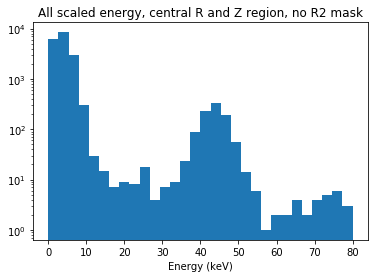

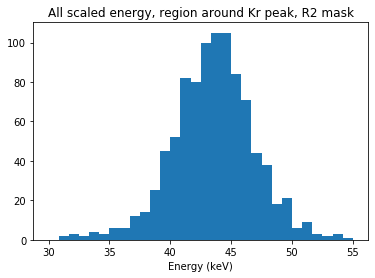

Correcting energies...
0 / 70386


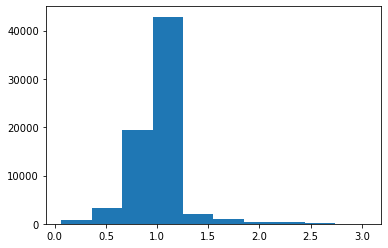

Fit a Gaussian with guess (A0, m0, s0) = (63.0, 1, 0.1590353541992586)


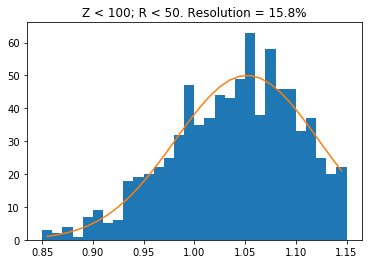

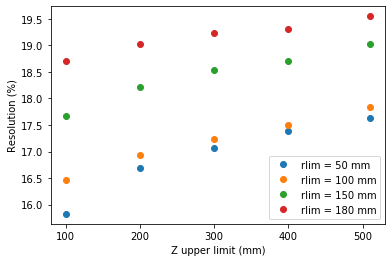

Innermost resolution =  15.82 %
Outermost resolution =  19.55 %
All resolutions: {100050: 15.824553407424965, 100100: 16.47185968099018, 100150: 17.66712732120784, 100180: 18.696132622596927, 200050: 16.68431589204527, 200100: 16.935883405414334, 200150: 18.217999663732044, 200180: 19.017469621457526, 300050: 17.063557875783893, 300100: 17.244343045317894, 300150: 18.530738652056485, 300180: 19.238728771700874, 400050: 17.382902839018517, 400100: 17.493420870910704, 400150: 18.714364379908197, 400180: 19.31459713455101, 510050: 17.624286065505412, 510100: 17.84342483053478, 510150: 19.02559390635909, 510180: 19.54863752301893}

================ CHECKING R2 CUT = 0.99 ================
Peak range = 141.7 , 1861.7
Selected percentage = 7.7 \%


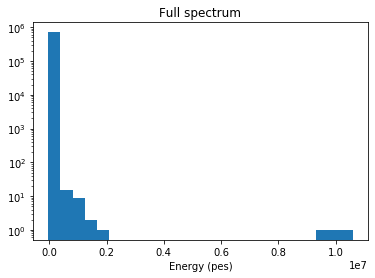

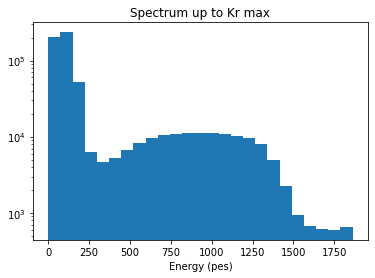

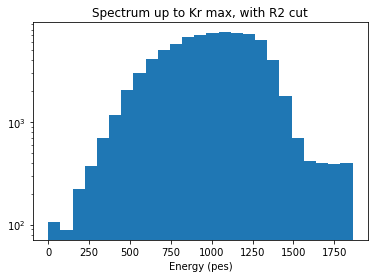

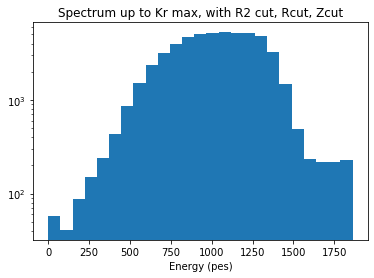

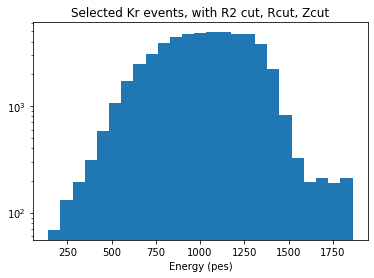

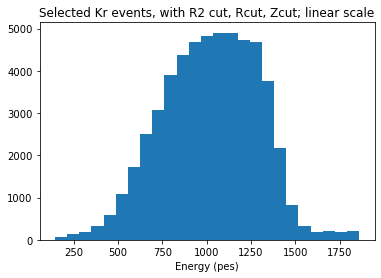

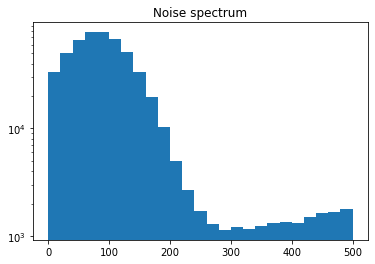

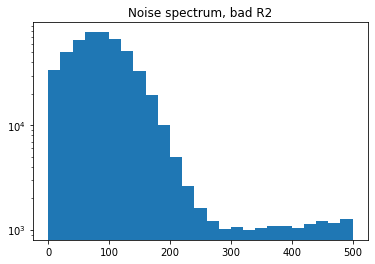

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


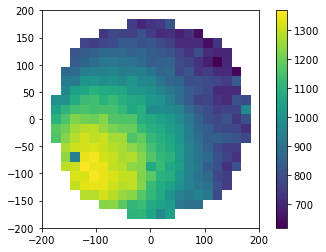

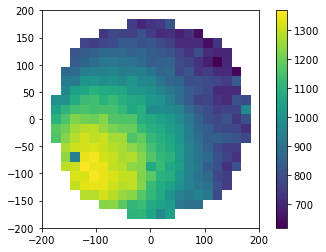

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 21.0
200000 / 595249
Est remaining = 19.9
300000 / 595249
Est remaining = 14.1
400000 / 595249
Est remaining = 9.1
500000 / 595249
Est remaining = 4.3


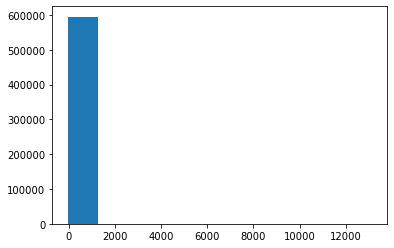

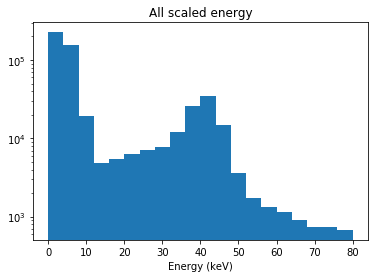

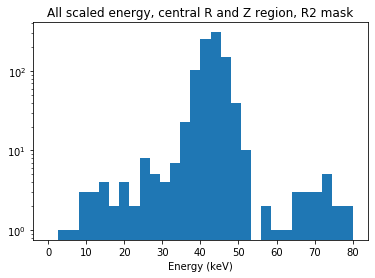

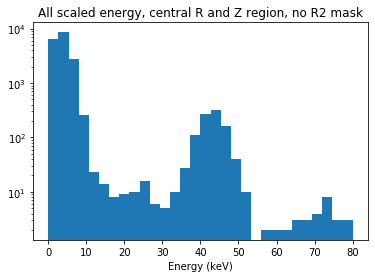

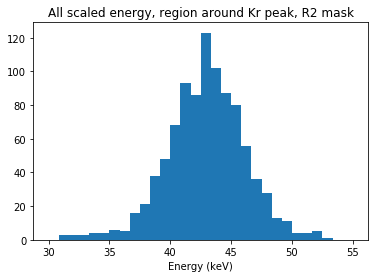

Correcting energies...
0 / 54570


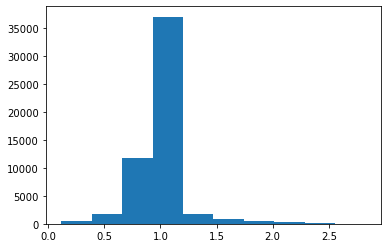

Fit a Gaussian with guess (A0, m0, s0) = (59.0, 1, 0.14079054435361837)


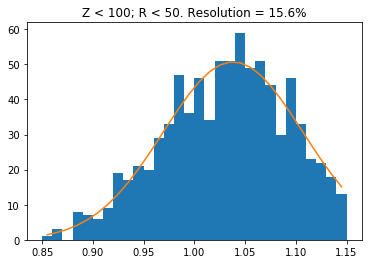

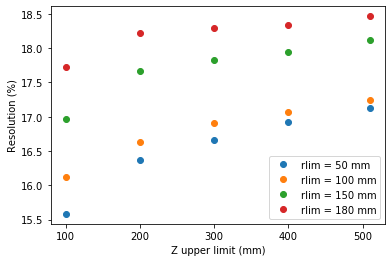

Innermost resolution =  15.58 %
Outermost resolution =  18.46 %
All resolutions: {100050: 15.583164327590296, 100100: 16.118502301808963, 100150: 16.96471908219728, 100180: 17.720094753375648, 200050: 16.375703034767078, 200100: 16.6375975888714, 200150: 17.66554099567111, 200180: 18.215851400657687, 300050: 16.657010509575393, 300100: 16.906384943375787, 300150: 17.83385039517451, 300180: 18.295890912513435, 400050: 16.91975181831611, 400100: 17.07373441764641, 400150: 17.940958501911084, 400180: 18.33925907744457, 510050: 17.123392686349998, 510100: 17.244842829266283, 510150: 18.121253499383883, 510180: 18.4649737577321}

================ CHECKING R2 CUT = 0.995 ================
Peak range = 188.6 , 1882.5
Selected percentage = 4.6 \%


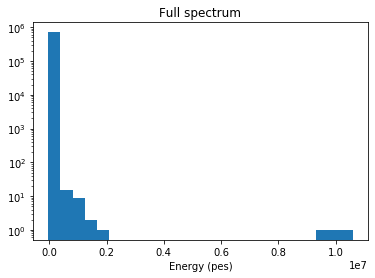

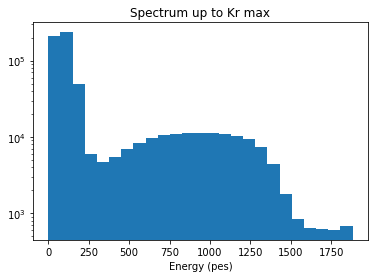

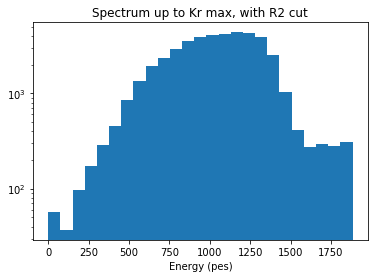

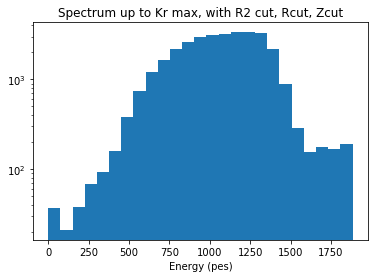

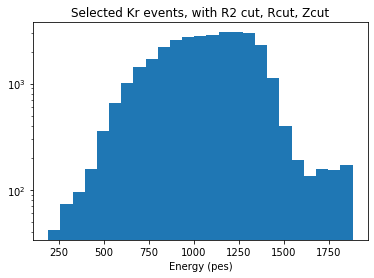

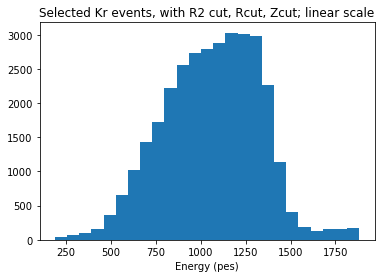

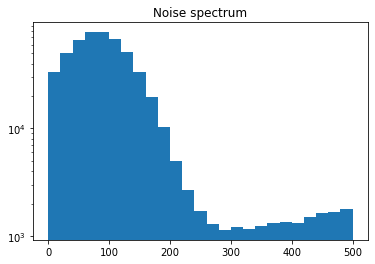

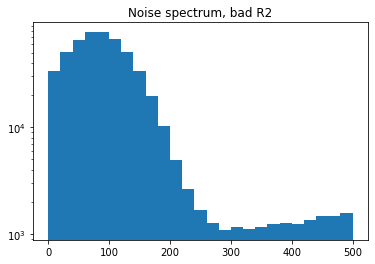

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


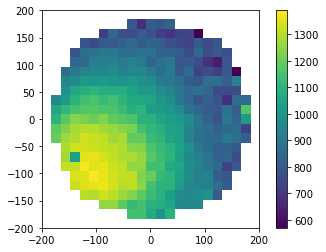

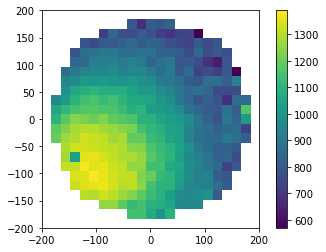

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 19.8
200000 / 595249
Est remaining = 16.5
300000 / 595249
Est remaining = 12.3
400000 / 595249
Est remaining = 7.9
500000 / 595249
Est remaining = 3.8


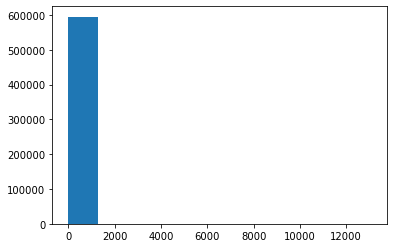

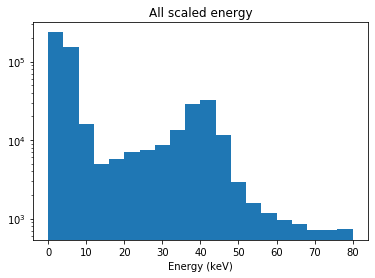

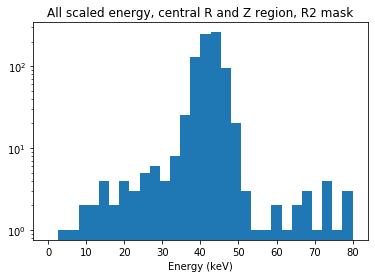

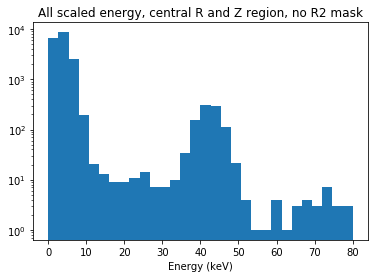

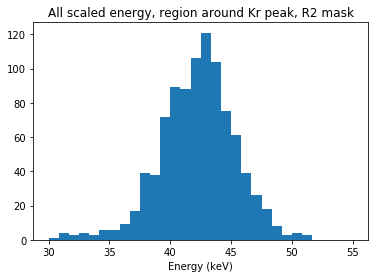

Correcting energies...
0 / 32401


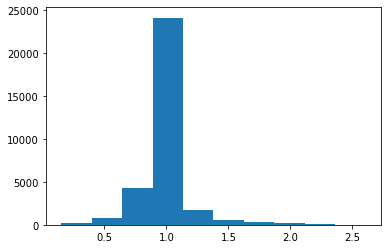

Fit a Gaussian with guess (A0, m0, s0) = (54.0, 1, 0.12897187041029334)


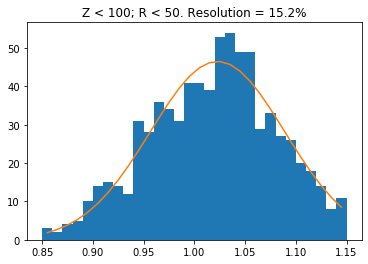

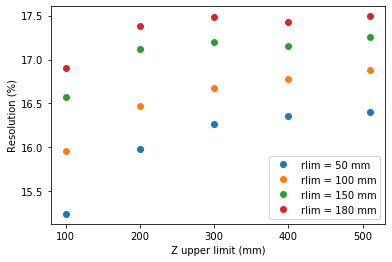

Innermost resolution =  15.24 %
Outermost resolution =  17.49 %
All resolutions: {100050: 15.240557933681677, 100100: 15.961908425867335, 100150: 16.578155773464953, 100180: 16.90665892508821, 200050: 15.981861224659971, 200100: 16.468557366772032, 200150: 17.11466467211697, 200180: 17.380660967842452, 300050: 16.266387025958633, 300100: 16.673645450816988, 300150: 17.202040939270766, 300180: 17.479306423039176, 400050: 16.35671858901001, 400100: 16.77898448574529, 400150: 17.15129965195389, 400180: 17.42641858771484, 510050: 16.400249976041543, 510100: 16.879926557691594, 510150: 17.250787588263176, 510180: 17.49288832332033}


In [19]:
# r2 scan
r2s = np.array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.92, 0.94, 0.96, 0.98, 0.99, 0.995])
res_vs_zr_vs_r2 = []
goodfit = []
for r2 in r2s:
    print('\n================ CHECKING R2 CUT =', r2, '================')
    try:
        self_res_vs_zr = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, r2)
        res_vs_zr_vs_r2.append(self_res_vs_zr)
        goodfit.append(True)
    except:
        goodfit.append(False)
goodfit = np.array(goodfit)

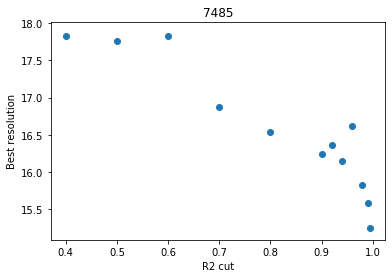

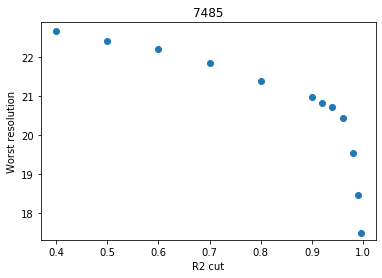

In [20]:
r2inner = [ list(x.values())[0] for x in res_vs_zr_vs_r2 ]
r2outer = [ list(x.values())[-1] for x in res_vs_zr_vs_r2 ]

plt.plot(r2s[goodfit], r2inner, 'o')
plt.ylim(min(r2inner)*0.99, max(r2inner)*1.01)
plt.title(runno)
plt.xlabel('R2 cut')
plt.ylabel('Best resolution')
plt.show()

plt.plot(r2s[goodfit], r2outer, 'o')
plt.ylim(min(r2outer)*0.99, max(r2outer)*1.01)
plt.title(runno)
plt.xlabel('R2 cut')
plt.ylabel('Worst resolution')
plt.show()

Peak range = -37.1 , 1899.1
Selected percentage = 11.0 \%


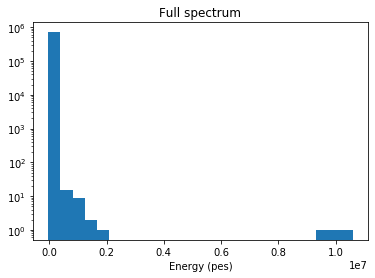

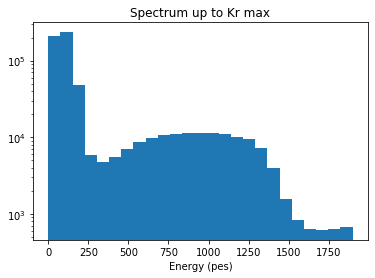

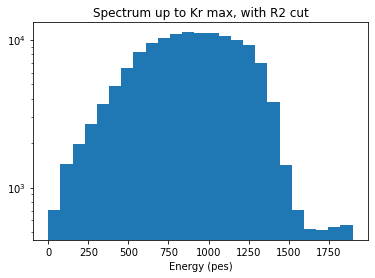

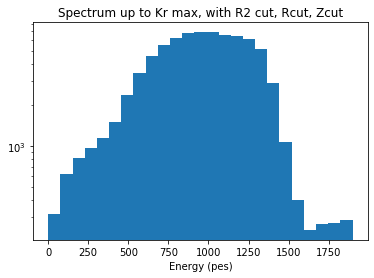

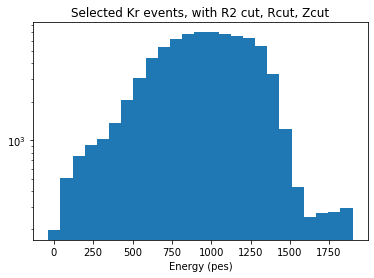

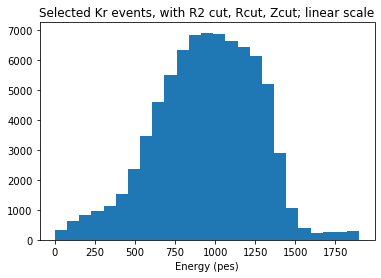

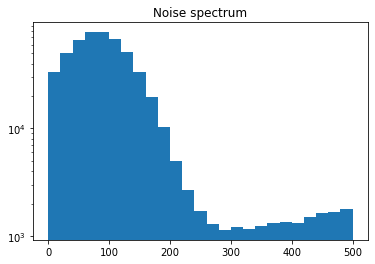

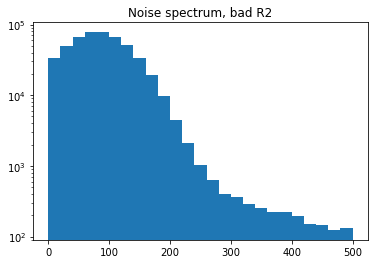

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


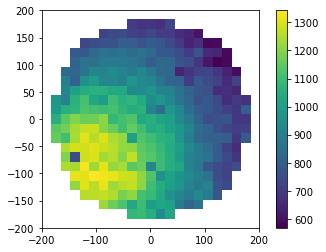

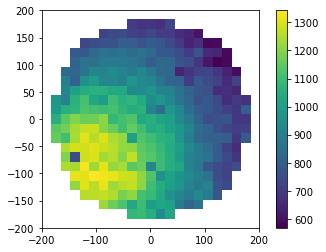

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 12.0
200000 / 595249
Est remaining = 9.4
300000 / 595249
Est remaining = 7.0
400000 / 595249
Est remaining = 4.7
500000 / 595249
Est remaining = 2.3


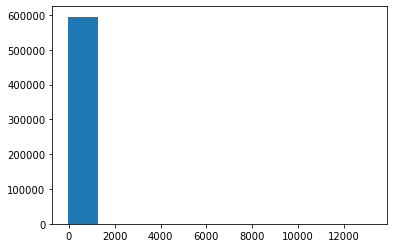

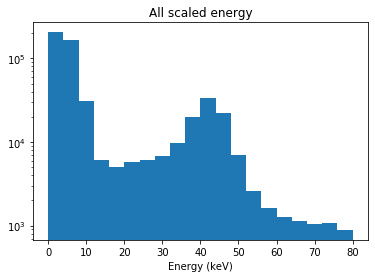

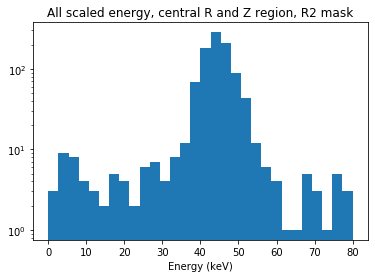

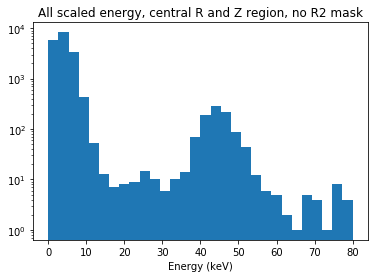

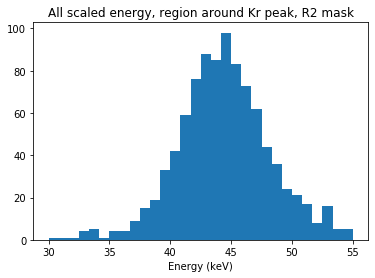

Correcting energies...
0 / 77969


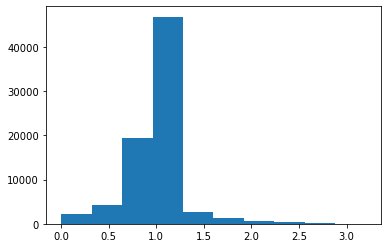

Fit a Gaussian with guess (A0, m0, s0) = (54.0, 1, 0.1858156597504021)


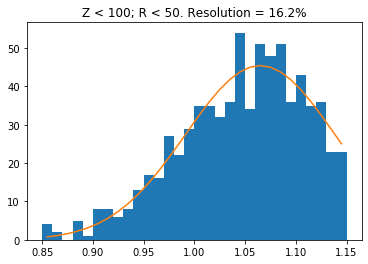

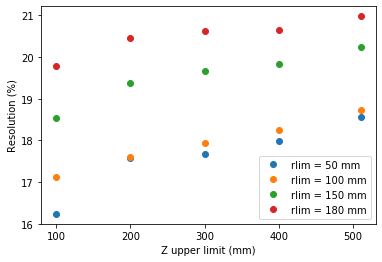

Innermost resolution =  16.24 %
Outermost resolution =  20.98 %
All resolutions: {100050: 16.237121746589033, 100100: 17.131023599784104, 100150: 18.544780384675484, 100180: 19.795384859059123, 200050: 17.58719333587108, 200100: 17.611237778323435, 200150: 19.376577910880215, 200180: 20.457835085006977, 300050: 17.686067747004273, 300100: 17.947196668967212, 300150: 19.67436573542728, 300180: 20.631646903279194, 400050: 17.98642460150309, 400100: 18.243558011487682, 400150: 19.82417765645557, 400180: 20.653702963782823, 510050: 18.572212929794123, 510100: 18.734171946295096, 510150: 20.24136690161987, 510180: 20.979803997329014}
Peak range = -27.0 , 1919.7
Selected percentage = 11.0 \%


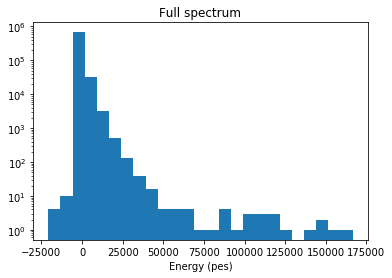

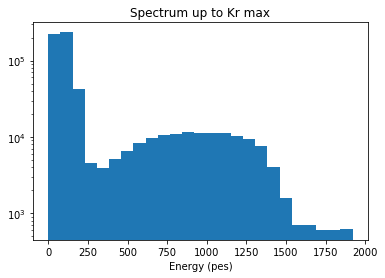

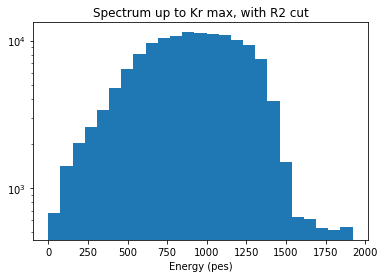

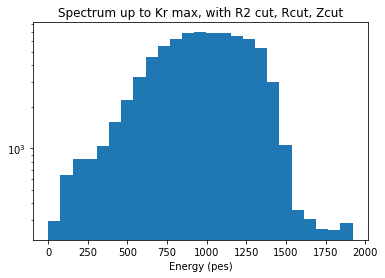

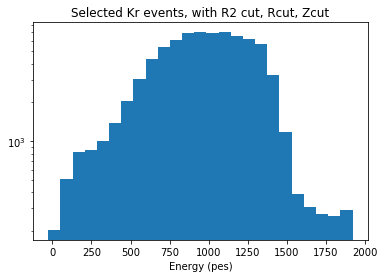

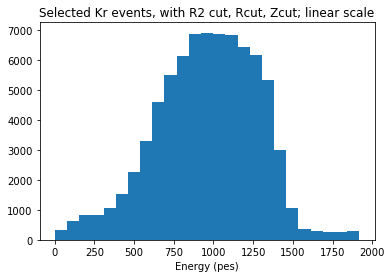

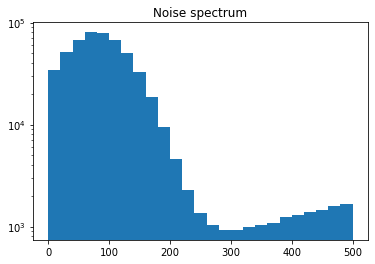

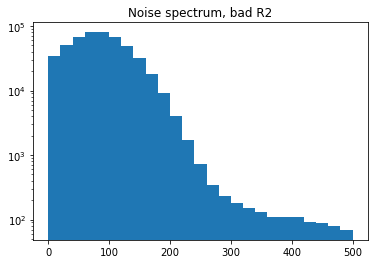

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


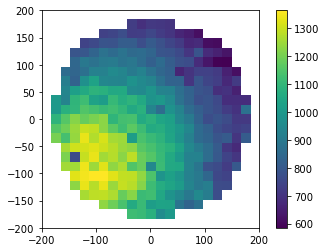

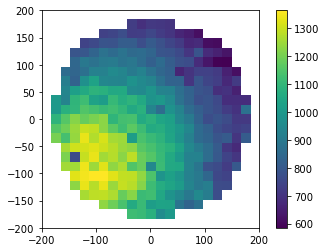

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 13.3
200000 / 595249
Est remaining = 10.6
300000 / 595249
Est remaining = 7.6
400000 / 595249
Est remaining = 4.9
500000 / 595249
Est remaining = 2.3


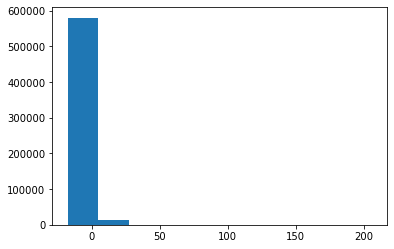

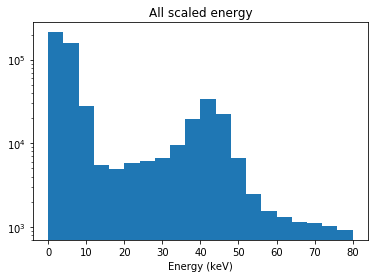

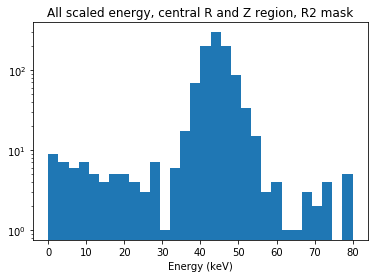

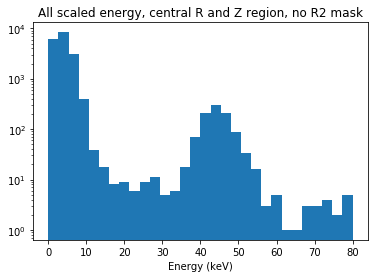

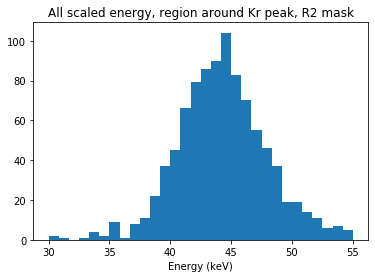

Correcting energies...
0 / 78019


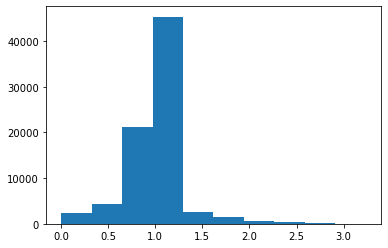

Fit a Gaussian with guess (A0, m0, s0) = (52.0, 1, 0.19758979164448676)


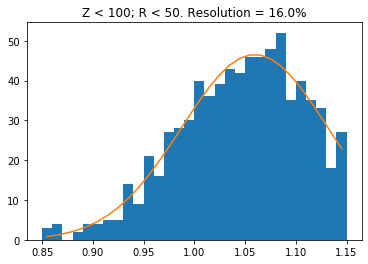

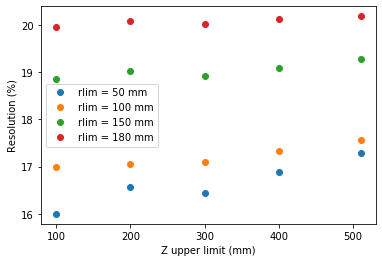

Innermost resolution =  16.0 %
Outermost resolution =  20.18 %
All resolutions: {100050: 15.999717365905855, 100100: 16.999826963373284, 100150: 18.850437574154647, 100180: 19.946593276820913, 200050: 16.578904031630454, 200100: 17.047737260191056, 200150: 19.014137543458055, 200180: 20.07178251423359, 300050: 16.436003649409816, 300100: 17.0904087655473, 300150: 18.91188458136665, 300180: 20.024411691263783, 400050: 16.894054805734907, 400100: 17.325763238235947, 400150: 19.079778119707, 400180: 20.114330597539574, 510050: 17.292004803623414, 510100: 17.566431564730532, 510150: 19.273373363431187, 510180: 20.181207117416886}
Peak range = -27.0 , 1919.7
Selected percentage = 11.0 \%


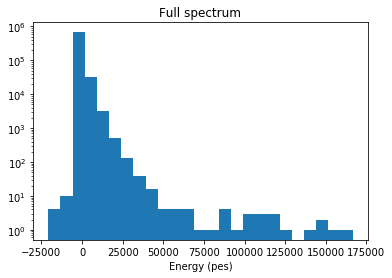

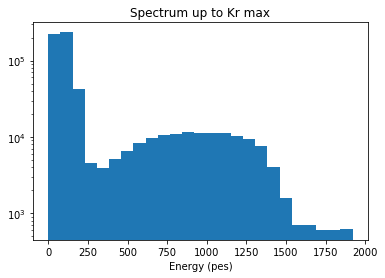

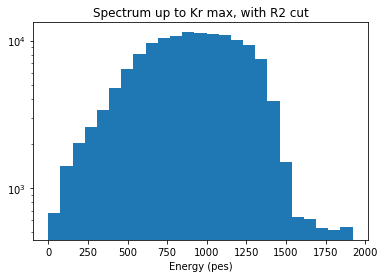

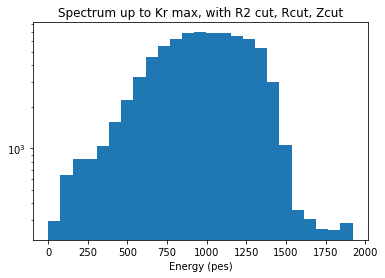

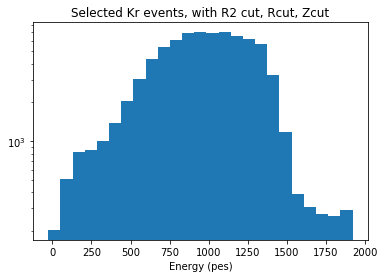

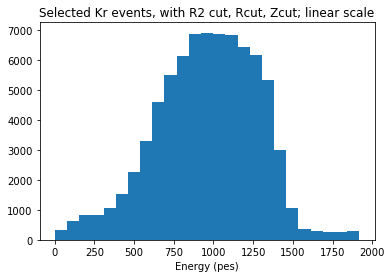

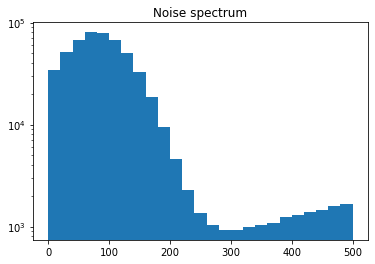

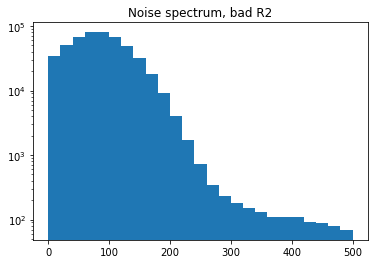

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


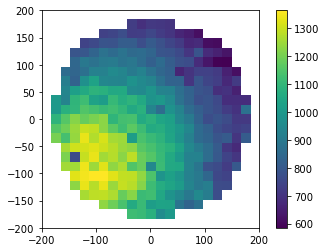

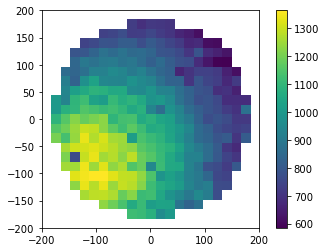

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 12.2
200000 / 595249
Est remaining = 10.4
300000 / 595249
Est remaining = 7.6
400000 / 595249
Est remaining = 4.9
500000 / 595249
Est remaining = 2.4


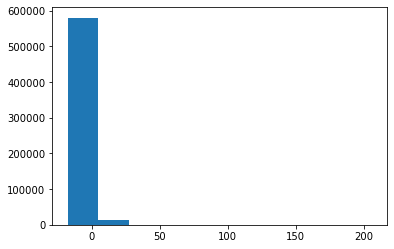

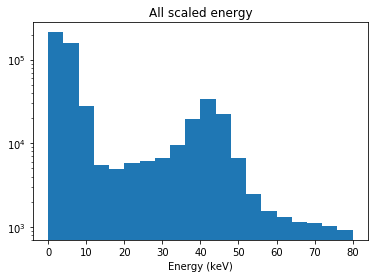

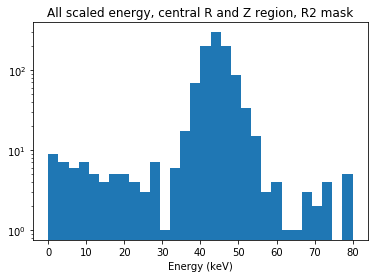

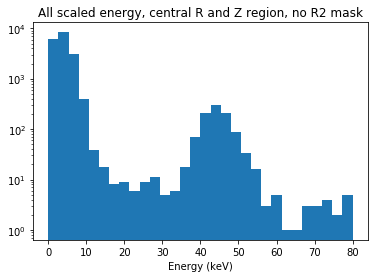

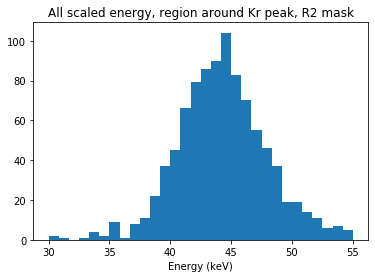

Correcting energies...
0 / 78019


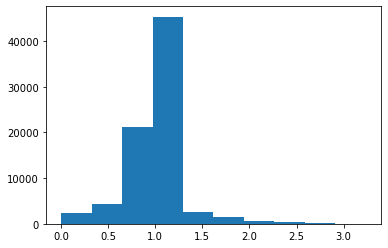

Fit a Gaussian with guess (A0, m0, s0) = (52.0, 1, 0.19758979164448676)


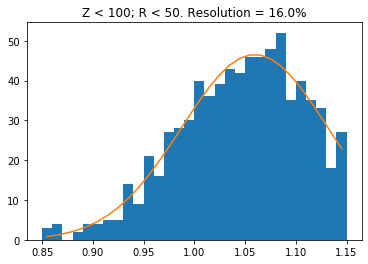

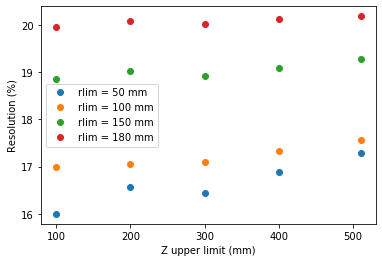

Innermost resolution =  16.0 %
Outermost resolution =  20.18 %
All resolutions: {100050: 15.999717365905855, 100100: 16.999826963373284, 100150: 18.850437574154647, 100180: 19.946593276820913, 200050: 16.578904031630454, 200100: 17.047737260191056, 200150: 19.014137543458055, 200180: 20.07178251423359, 300050: 16.436003649409816, 300100: 17.0904087655473, 300150: 18.91188458136665, 300180: 20.024411691263783, 400050: 16.894054805734907, 400100: 17.325763238235947, 400150: 19.079778119707, 400180: 20.114330597539574, 510050: 17.292004803623414, 510100: 17.566431564730532, 510150: 19.273373363431187, 510180: 20.181207117416886}


In [21]:
try:
    pre_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)
    post_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_post, 0.9)
    avg_res = check_resolution(histat_Zgauss, histat_events_energy_subtracted_avg, 0.9)
except:
    pass

In [22]:
try:
    print('Inner res for pre, post, avg:')
    print(round(list(pre_res.values())[0], 2), ',', round(list(post_res.values())[0], 2), ',', round(list(avg_res.values())[0], 2))
    print('Outer res for pre, post, avg:')
    print(round(list(pre_res.values())[-1], 2), ',', round(list(post_res.values())[-1], 2), ',', round(list(avg_res.values())[-1], 2))
except:
    pass

Inner res for pre, post, avg:
16.24 , 16.0 , 16.0
Outer res for pre, post, avg:
20.98 , 20.18 , 20.18


Peak range = -37.1 , 1899.1
Selected percentage = 11.0 \%


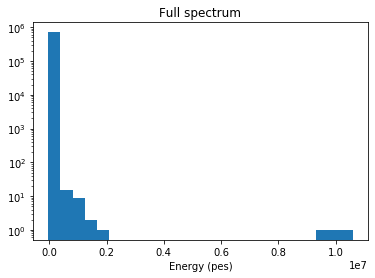

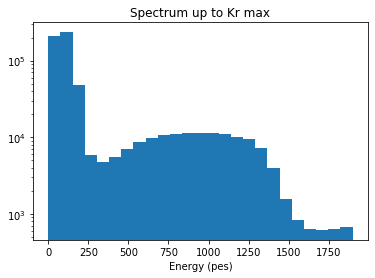

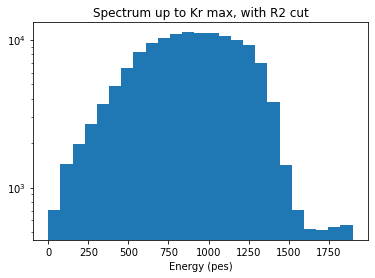

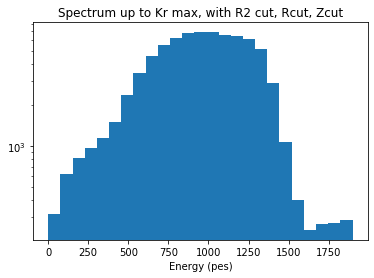

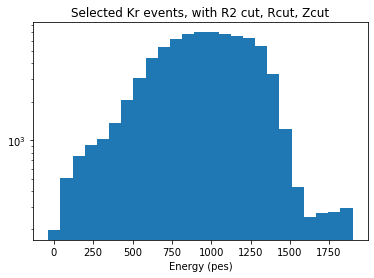

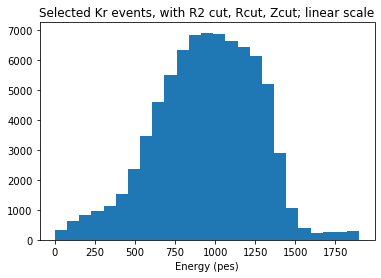

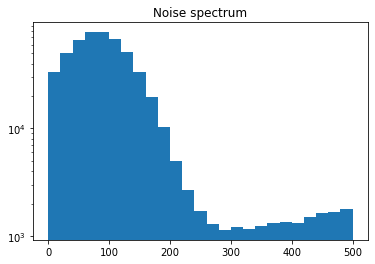

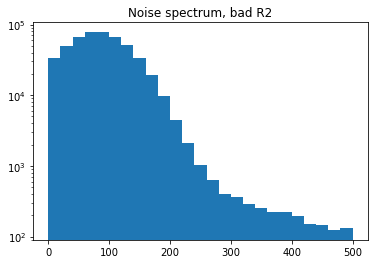

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


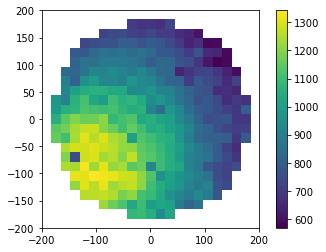

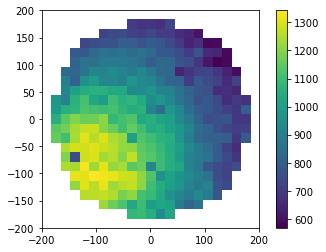

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 11.3
200000 / 595249
Est remaining = 9.5
300000 / 595249
Est remaining = 6.9
400000 / 595249
Est remaining = 4.7
500000 / 595249
Est remaining = 2.3


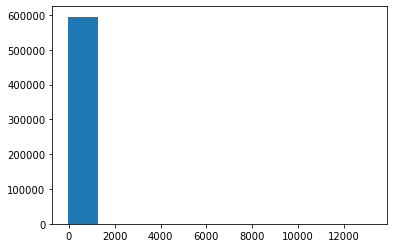

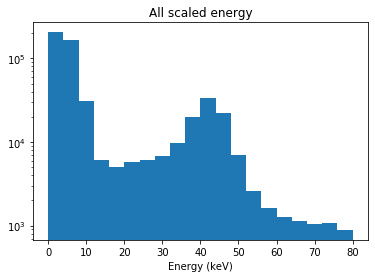

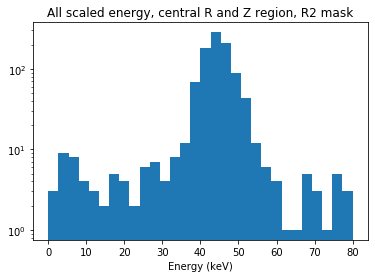

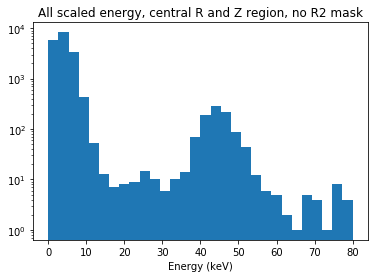

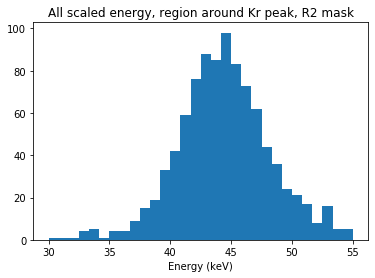

Correcting energies...
0 / 77969


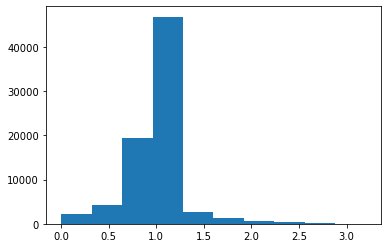

Fit a Gaussian with guess (A0, m0, s0) = (54.0, 1, 0.1858156597504021)


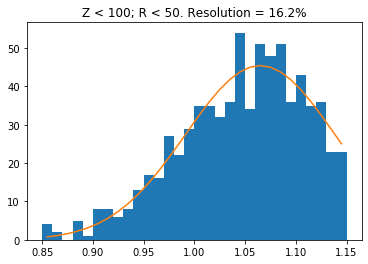

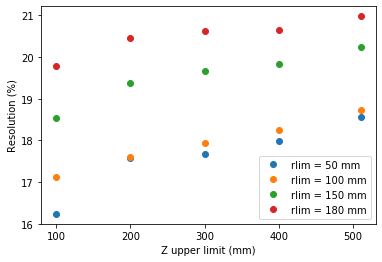

Innermost resolution =  16.24 %
Outermost resolution =  20.98 %
All resolutions: {100050: 16.237121746589033, 100100: 17.131023599784104, 100150: 18.544780384675484, 100180: 19.795384859059123, 200050: 17.58719333587108, 200100: 17.611237778323435, 200150: 19.376577910880215, 200180: 20.457835085006977, 300050: 17.686067747004273, 300100: 17.947196668967212, 300150: 19.67436573542728, 300180: 20.631646903279194, 400050: 17.98642460150309, 400100: 18.243558011487682, 400150: 19.82417765645557, 400180: 20.653702963782823, 510050: 18.572212929794123, 510100: 18.734171946295096, 510150: 20.24136690161987, 510180: 20.979803997329014}
Peak range = -8.3 , 1888.2
Selected percentage = 9.9 \%


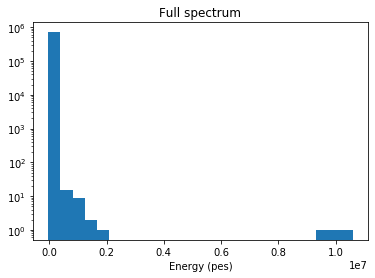

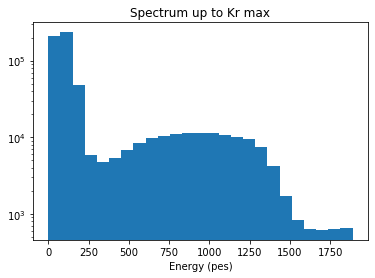

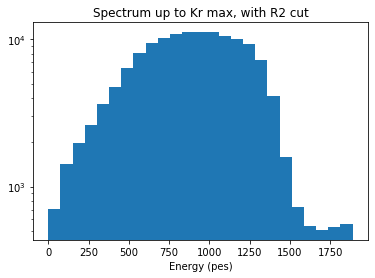

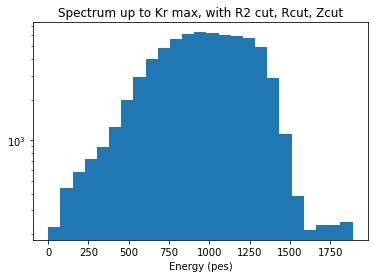

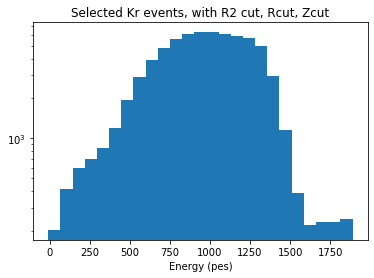

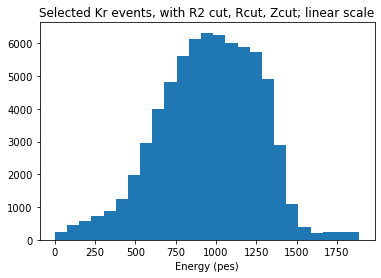

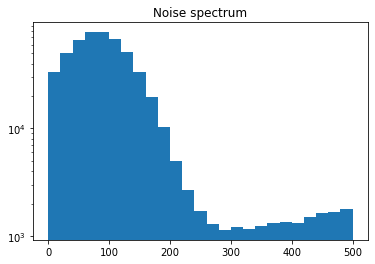

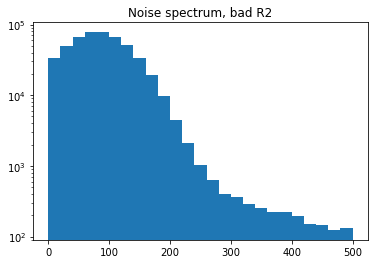

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


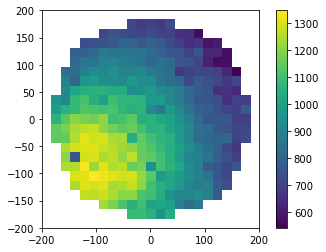

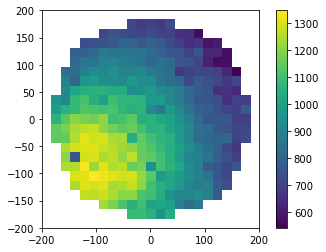

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 11.7
200000 / 595249
Est remaining = 9.5
300000 / 595249
Est remaining = 7.0
400000 / 595249
Est remaining = 4.6
500000 / 595249
Est remaining = 2.3


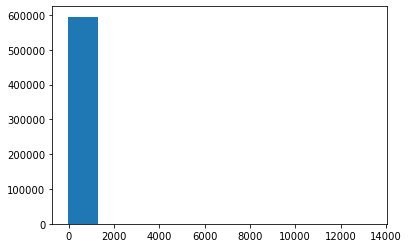

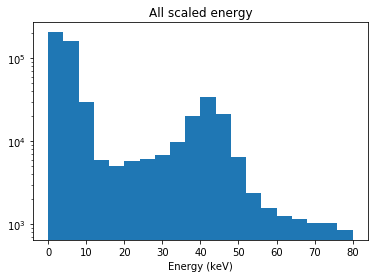

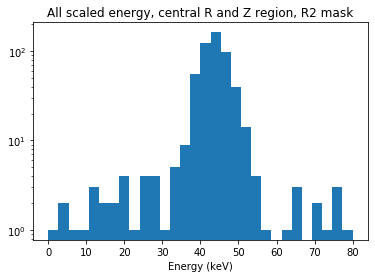

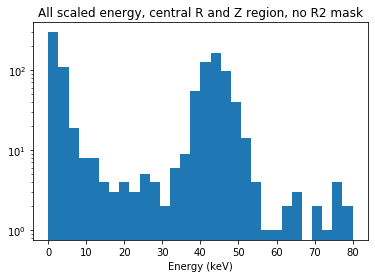

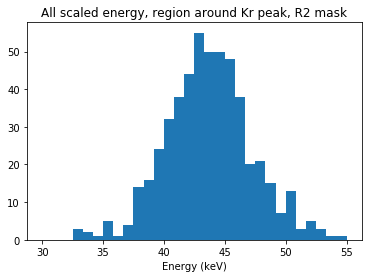

Correcting energies...
0 / 70077


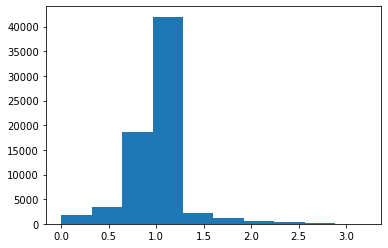

Fit a Gaussian with guess (A0, m0, s0) = (32.0, 1, 0.16210232210670847)


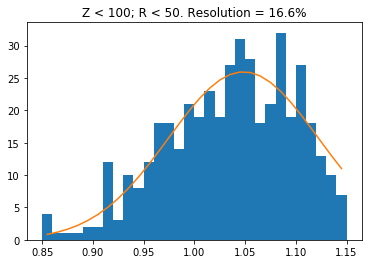

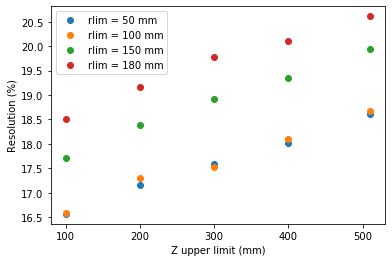

Innermost resolution =  16.57 %
Outermost resolution =  20.61 %
All resolutions: {100050: 16.567296994210917, 100100: 16.580399692375067, 100150: 17.720060769022478, 100180: 18.509346688233805, 200050: 17.16620247516069, 200100: 17.29321576252961, 200150: 18.380562582456857, 200180: 19.166809839899717, 300050: 17.587739293313764, 300100: 17.527065807114013, 300150: 18.92411474232669, 300180: 19.772412378862317, 400050: 18.02276433942072, 400100: 18.097900491970226, 400150: 19.350808530379727, 400180: 20.10835387074756, 510050: 18.607651923935645, 510100: 18.674957284590963, 510150: 19.940481572100488, 510180: 20.61146826000784}


In [23]:
try:
    res_gauss = check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)
    res_rms = check_resolution(histat_Zrms, histat_events_energy_subtracted_pre, 0.9)
except:
    pass

In [24]:
try:
    print('Inner res for rms, gauss:')
    print(round(list(res_rms.values())[0], 2), ',', round(list(res_gauss.values())[0], 2))
    print('Outer res for rms, gauss:')
    print(round(list(res_rms.values())[-1], 2), ',', round(list(res_gauss.values())[-1], 2))
except:
    pass

Inner res for rms, gauss:
16.57 , 16.24
Outer res for rms, gauss:
20.61 , 20.98


Peak range = -37.1 , 1899.1
Selected percentage = 11.0 \%


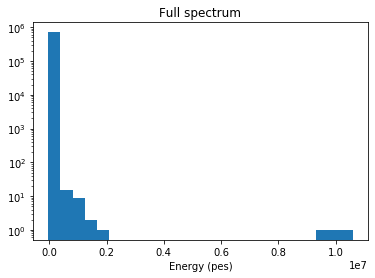

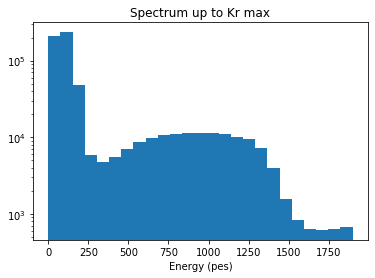

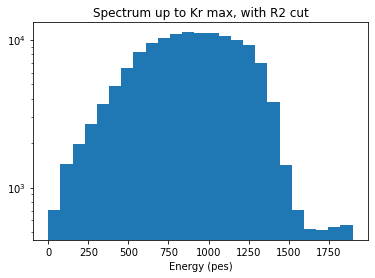

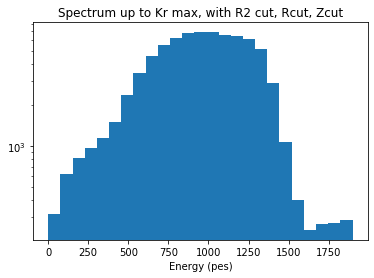

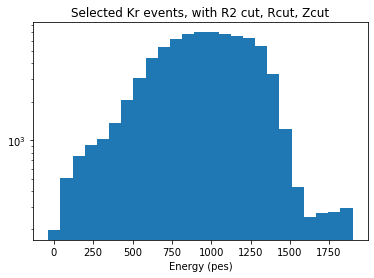

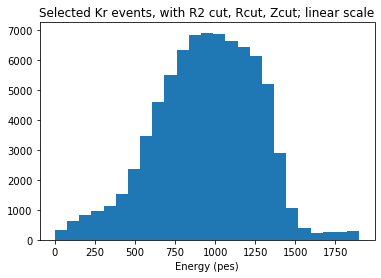

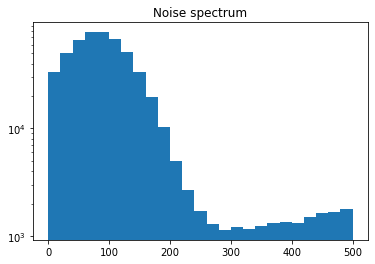

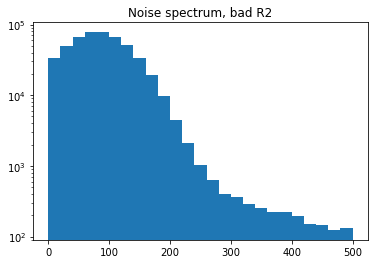

/Users/jmhaefner/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel/__main__.py:88: RuntimeWarning: invalid value encountered in true_divide


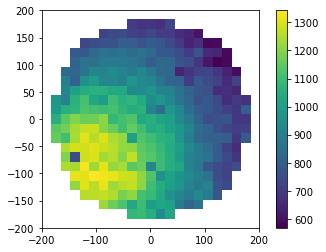

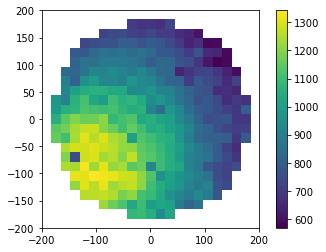

Correcting energies...
0 / 595249
100000 / 595249
Est remaining = 9.3
200000 / 595249
Est remaining = 7.5
300000 / 595249
Est remaining = 5.5
400000 / 595249
Est remaining = 3.6
500000 / 595249
Est remaining = 1.8


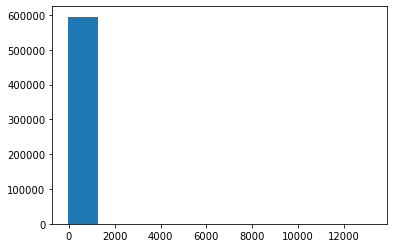

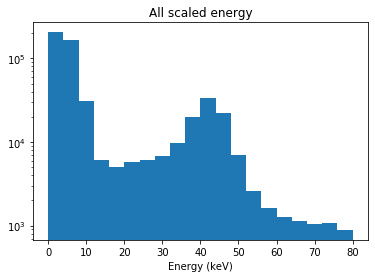

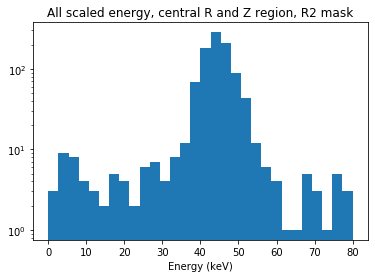

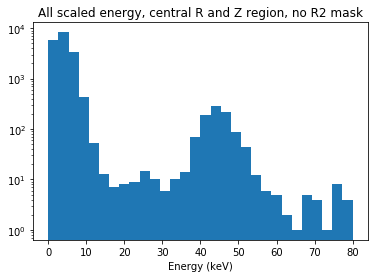

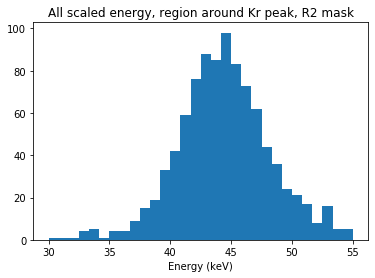

Correcting energies...
0 / 77969


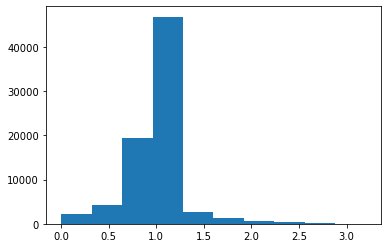

Fit a Gaussian with guess (A0, m0, s0) = (54.0, 1, 0.1858156597504021)


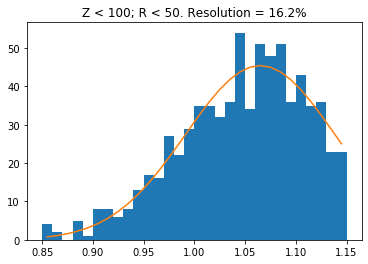

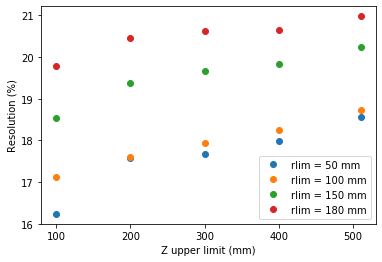

Innermost resolution =  16.24 %
Outermost resolution =  20.98 %
All resolutions: {100050: 16.237121746589033, 100100: 17.131023599784104, 100150: 18.544780384675484, 100180: 19.795384859059123, 200050: 17.58719333587108, 200100: 17.611237778323435, 200150: 19.376577910880215, 200180: 20.457835085006977, 300050: 17.686067747004273, 300100: 17.947196668967212, 300150: 19.67436573542728, 300180: 20.631646903279194, 400050: 17.98642460150309, 400100: 18.243558011487682, 400150: 19.82417765645557, 400180: 20.653702963782823, 510050: 18.572212929794123, 510100: 18.734171946295096, 510150: 20.24136690161987, 510180: 20.979803997329014}


{100050: 16.237121746589033,
 100100: 17.131023599784104,
 100150: 18.544780384675484,
 100180: 19.795384859059123,
 200050: 17.58719333587108,
 200100: 17.611237778323435,
 200150: 19.376577910880215,
 200180: 20.457835085006977,
 300050: 17.686067747004273,
 300100: 17.947196668967212,
 300150: 19.67436573542728,
 300180: 20.631646903279194,
 400050: 17.98642460150309,
 400100: 18.243558011487682,
 400150: 19.82417765645557,
 400180: 20.653702963782823,
 510050: 18.572212929794123,
 510100: 18.734171946295096,
 510150: 20.24136690161987,
 510180: 20.979803997329014}

In [25]:
# Output the proper map
check_resolution(histat_Zgauss, histat_events_energy_subtracted_pre, 0.9)

In [26]:
print('Total time =',  round((time() - t0)/60,1), 'minutes')

Total time = 20.2 minutes
